# Open Program Notebook

# Table of Contents

- [Introduction](#introduction)
- [Importing Libraries](#importing-libraries)
- [Setting up GPU-Accelerated TensorFlow](#setting-up-gpu-accelerated-tensorflow)
- [Phase 1](#phase-1)
  - [Data Sourcing](#data-sourcing)
  - [Analytic Approach](#analytic-approach)
- [Phase 2](#phase-2)
  - [Data Requirements](#data-requirements)
  - [Data Collection](#data-collection)
  - [Data Understanding](#data-understanding)
  - [Data Preparation](#data-preparation)
  - [Data Understanding - Continuation](#data-understanding---continuation)
- [Phase 3](#phase-3)
  - [Pre Processing](#pre-processing)
  - [Modeling](#modeling)
  - [Evaluation](#evaluation)
- [Phase 4](#phase-4)
  - [Conclusion](#conclusion)

# Introduction

This notebook contains the complete project of my open program; the implementation of a movie rating prediction system using Deep Learning. The goal of this system is to predict the rating of a movie that the user may watch. This rating can then be used to gauge potential interest in movies for the user, and create targeted recommendations based on this information. This process is performed in four phases:
- [Data Sourcing](#phase-1)
- [Data Understanding and Cleaning](#phase-2)
- [Pre-Processing and Modeling](#phase-3)
- [Conclusion](#phase-4)

Each section contains a number of code blocks. Preceding each code block is a paragraph of text, which aims to inform the reader about the purpose of the code block beneath it. Contained within each is an in-depth explanation of what each code block does, why it is done and the result it returns. Finally, if applicable, it may also contain a conclusion where points of note and my thoughts about the result are noted.

For this Open Program, I have opted to implement a `Movie Rating Prediction System`. My main plan is to use `The Movies Dataset`, which we will be covering in more detail in the [Data Understanding](#data-understanding) section.

# Importing Libraries

In this notebook, a number of libraries are used to provide me with the necessary functions to make predictions. In preparation of running the code, these libraries need to be imported first. The following code manages importing all the libraries I need later in this notebook.

In [2]:
from IPython.utils import io
import os
import sys
# Set TensorFlow log level to suppress informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import string
import re
import ast
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from typing import Dict, Text
from ast import literal_eval

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import tensorflow as tf
from absl import logging
import tensorflow_recommenders as tfrs
# To create deep learning models
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
# To shift lists
from collections import deque
import gc

import warnings
warnings.filterwarnings('ignore')

<hr/>

# Setting up GPU-Accelerated TensorFlow

In order to make TensorFlow training faster, I opted to use `Apple's` [tensorflow-metal](https://developer.apple.com/metal/tensorflow-plugin/) distribution, that allows me to use my computer's dedicated GPU for training. Since parallel compute operations run much faster on a GPU rather than a CPU, this will bring good performance improvements to this notebook.

### What is TensorFlow?

TensorFlow is an `open-source Machine Learning libary`, intially developed by `Google's Brain division`, released in 2015. Since then it has seen multiple updates and `rapid industry adoption` when it comes to scientific projects and retail products. Tensor has made significant impacts in the `Medical, Social media, Education and Retail` industries and is used by big companies, such as `General Electric, Twitter, and Carousell`.

### What is Metal?

`Metal` is `Apple's propietary Graphics API` on Mac systems, similar to `DirectX on Windows`. The developers at Google teamed up with Apple to create a separate distribution under the `tensorflow-metal` name that can take advantage of the `Metal Performance Shaders`, or `MPS` and the `Metal Rendering Engine`, thus `allowing for parallel computing operations to be run on the GPU`. This allows for `better performance` and `shortened model train times`.

### Why TensorFlow?

Going into this project, I could have either chosen to use `Tensor` or `PyTorch`. `PyTorch` is another `open-source Machine learning library`, this time built on top of `Torch` by `Facebook, now Meta's AI division`, and is usually `very popular in computer vision and natural language processing fields`. I however chose `TensorFlow` over it due to a bit of past experience I had from tinkering with the library.

In [2]:
devices = tf.config.list_physical_devices()
print(devices)
tf.debugging.set_log_device_placement(True)
a=tf.random.normal([100,100])
b=tf.random.normal([100,100])
c = a*b

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
shape: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
RandomStandardNormal: (RandomStandardNormal): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/devi

<hr/>

# Phase 1

# Data Sourcing

#### The Dataset

For this project, I opeted to use [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?datasetId=3405&sortBy=voteCount&searchQuery=Deep+Learning), from `Kaggle`. These files contain metadata for all `45,000 movies listed in the Full MovieLens Dataset`. The `dataset` consists of movies `released on or before July 2017`. Data points include `cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages`. This dataset also has files containing `26 million ratings from 270,000 users for all 45,000 movies`. Ratings are on a `scale of 1-5` and have been obtained from the official `GroupLens` website.

I ended up choosing this dataset for this project, since it was a heavily extened version of the `MovieLens100k` and `MovieLens-1M` sets that were used in the first Challenge of this Semester, in the form of all the new data points mentioned prior.

#### Bias

I do believe there is some bias in the sets, especially in the `ratings` one. What leads me to believe this is that the ratings are user-sourced, therefore, certain beliefs, individual views, and thoughts may have a biased impact on (some) ratings. As far as the movies and the metadata are concerned, I don't think there is much bias to be found, as we will later discuss during the [Data Understanding - Continuation](#data-understanding---continuation) section.

# Analytic Approach

This project will focus on recommending movie ratings for users using a `Deep Learning / Neural Network` model. The target variable for this will be `ratings`.

<hr/>

# Phase 2

During the second phase, I will take a critical look at the dataset that I will be using, and prepare it for the modeling phase. This includes looking at potential ways of expanding the data available to me, cleaning up the dataset (merging tables, filling empty columns, converting values to the proper datatypes) and visualizing the data in a variety of manners. I will also take a critical look at the dataset, it's advantages, disadvantages, points of concern and potential bias, and write these down.

This section is split up in the following sub-sections:
- [Data Requirements](#data-requirements): This section mentions the additional requirements which the dataset may contain in future iterations.
- [Data Collection](#data-collection): This section details the steps I took to clean up the dataset and prepare it for modeling.
- [Data Understanding](#data-understanding): This section visualizes the data, and contains a critical look on each, noting potential bias.

# Data Requirements

In the next iterations of this project, it would be possible to add more `features` to the sets. Some of the data that would be possible to fetch and implement would be as follows: 

- Constant flux of new movies being released
- `Expanded ratings` such as `ratings` from bigger movie databases like:
  - `Rottern Tomatoes`
  - `Metacritic`
  - `IMDb`

Since the dataset we're currently using has `most of the features that would be useful in creating an ample recommendation engine`, dealing with expanded ratings and newly released movies will be a good starting point. 

# Data Collection

In this segment, we'll collect all of the data I need for my model and perform the necessary steps to make it as complete and readable as possible. This is done to make the dataset as complete, transparent and legible for humans as it possibly can be, whilst also improving the accuracy and speed of the model. Actions that we'll be performing in this section includes merging datasets, converting column values to an appropriate, human-legible representation, determining the amount of missing information and making it more complete by filling up this data.

### Updating the Data

Further updating the datasets could be done in a few ways. By using the API's provided by big databases like [IMDb](https://developer.imdb.com), [Rottern Tomatoes](https://developer.fandango.com/rotten_tomatoes), or [Metacritic](https://rapidapi.com/Prastiwar/api/metacriticapi) we can theoretically get the influx of data and new movie information and metadata that we are missing, in further iterations. For further data updating, scripts can be built in order to automatically take care of these Data Collection Tasks. The same bias issue will however remain unchanged by following this route. A good candidate for getting some more updated data would be [IMDB Movies Dataset](https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows) from `Kaggle`, however this set only has entries for the `top 1000 movies on IMDb`. While it is a good data source, it's not nearly enough compared to the amount of data we currently have on hand. 

Let's look at the data that we currently have on hand. We'll first start by loading in and displaying the raw datasets that we will be using: the `credits, keywords, movies, ratings and links` datasets, obtained from [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?datasetId=3405&sortBy=voteCount&searchQuery=Deep+Learning), from `Kaggle`. These datasets contain a large number of movie properties that, when combined and processed, can give us both insights in what users tend to watch and make accurate predictions based on a number of properties. We will be explaining the contents of these datasets in detail in the [Data Understanding](#data-understanding) section of my document.

In [3]:
credits = pd.read_csv('./assets/tmds/credits.csv')
keywords = pd.read_csv('./assets/tmds/keywords.csv')
movies = pd.read_csv('./assets/tmds/movies_metadata.csv')
ratings = pd.read_csv('./assets/tmds/ratings.csv', parse_dates=['timestamp'])
links = pd.read_csv('./assets/tmds/links.csv')

In [4]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
credits.head()  

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [6]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

From the outputs above, we can see that the sets are pretty messy, so we will have to clean these up in order to perform proper EDA. Said EDA will be performed in the [Data Understanding - Continuation](#data-understanding---continuation) section. In order to avoid confusion on the data types and the rest of the data we'll be working with, we'll quickly go over the [Data Understanding](#data-understanding) section.

# Data Understanding

The data itself is split between a few `.csv` files, those being `movies_metadata.csv`, `ratings.csv`, `ratings_small.csv`, `credits.csv`, `keywords.csv`, `links.csv`, and `links_small.csv`. Below, I will make an overview of all the columns present in those files and explain the data that's contained within.

> Data Structures

For `movies_metadata.csv` we have the following columns:
- `adult` - Boolean for if a film is Adult rated.
- `belongs_to_collection` - Boolean for if a movie belongs to a collection.
- `budget` - A movie's budget.
- `genres` - A movie's genre.
- `homepage` - The main website of a movie.
- `id` - The id of a movie.
- `imdb_id` - A movie's id, but this time from IMDb.
- `original_language` - Original spoken language of the movie.
- `original_title` - Original title of a movie.
- `overview` - Contains all the information about a movie in a concatenated form.
- `popularity` - Popularity of a movie.
- `poster_path` - Link to a movie's poster.
- `production_companies` - A movie's production company/studio.
- `production_countries` - Information about which countries the movies was shot in.
- `release_date` - A movie's release date.
- `revenue` - Box office revenue.
- `runtime` - Runtime of a movie.
- `spoken_languages` - Spoken languages in the movie.
- `status` 
- `tagline` - A list of all tags.
- `title` - A movie's title.
- `video` - A link to a movie's trailer.
- `vote_average` - Average votes.
- `vote_count` - Average count of votes.

For `ratings.csv` we have the following columns:
- `userId` - The lines within this file are ordered first by `userId`.
- `movieId` - A movie's id.
- `rating`(s) are made on a 5 star scale, with half star increments.
- `timestamp`(s) represent the Unix time.

`ratings_small.csv` is a `subset` of `100,000 ratings` from `700 users` on `9,000 movies` from the `main ratings` set. 

In `keywords.csv` we have the following columns:
- `id` - A movie's id
- `keywords` - Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

In `credits.csv` we have the following columns:
- `cast` - Contains information about the Cast of a movie in a JSON format.
- `crew` - Contains information about the Crew of a movie in a JSON format.
- `id` - A movie's id

In `links.csv` we have the following columns:
- `movieId` - A movie's id.
- `imdbId` - A movie's id from `IMDb`.
- `tmdbId` - A movie's id from `TMDb`.

In `links_small.csv` we have the following columns:
- `movieId` - A movie's id.
- `imdbId` - A movie's id from `IMDb`.
- `tmdbId` - A movie's id from `TMDb`.

The main difference between `links` and `links_small` is the `amount of data contained`. `links_small` is a `subset of 9,000 movies` of the main `links` set.

# Data Preparation

Let's clean up the data. Our objective will be to get to a organized, easy to read and comprehensive dataset, that can be extensively analyzed and visualized in the subsequent [Data Visualization](#data-visualization) section.

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

As shown in the output above, the dataset `in it's current state contains numerous fields that are illegible or using the incorrect datatype, and contains a number of fields in which no data is present at all`. Before we start looking at the data and come to conclusions, we will first `clean up the dataset by addressing these problems`, with the objective of getting an organized, easy to read and comprehensive dataset, that can be extensively analyzed and visualized in the subsequent [Data Understanding](#data-understanding---continuation) section. 

Cleaning the dataset has a number of benefits that will help me increase performance and prediction accuracy of the model. Following are the two main benefits from this process:
- `Identifying missing values`: Missing values in a dataset can have a significant impact on machine learning models. They can lead to biased or inaccurate results, affect the performance of the model, or cause errors during training or prediction. By calculating the total number of missing values in the dataset, one can gain insights into the extent of missing data and its potential impact on the model's performance.
- `Quantifying missing data`: Calculating the percentage of missing values provides a measure of the data quality and completeness. It helps in understanding the `overall data integrity` and `determining whether further steps are necessary` to handle missing values.

The first step in this process is to calculate the percentage of missing data. This will give us an indication of how much data is missing from the dataset and how much impact it could have on both predictions and data visualizations later on in the notebook.
To calculate this value, we perform the following steps:
- We start off by `calculating` the total number of `missing values in the movies dataset` with the `movies.isnull().sum().sum()` line. `movies.isnull()` returns a `boolean DataFrame` where `True` represents `missing values`, `sum() is then called twice to get the sum of missing values in each column` and finally the `sum of all columns is calculated` to get the `total count of missing values`. 
- Further on, the `np.product(movies.shape)` line `calculates the total number of cells in the movies dataset`. `movies.shape` `returns a tuple` with the `dimensions of the dataset` , and `np.product()` is used to `calculate the product of these dimensions`, `giving the total number of cells`.
- Next up, the `(totalMissingValues / totalCells) * 100` expression `calculates the percentage of missing values` by `dividing the total number of missing values by the total number of cells` and then `multiplying by 100`.
- Finally, the `results` with the `percentage of missing values` are `print()ed`.

In [10]:
# Calculate the total number of missing values in the dataset
totalMissingValues = movies.isnull().sum().sum()

# Calculate the total number of cells in the dataset
totalCells = np.product(movies.shape)

# Calculate the percentage of missing values
percent_missing = (totalMissingValues / totalCells) * 100

# Print the result
print("Percent of missing values = " + str(percent_missing))

Percent of missing values = 9.674078798809367


From the function's output above, we can see that we have `~9.6%` of data that is currently `missing from the movies dataset`. These values range from missing `tags, runtime, collection info and language`, among other values. This means that the model would have a considerable loss in accuracy when using the dataset in it's current state. To ensure the dataset is in a clean and suitable format for both subsequent analysis or modeling tasks, and improving the quality and reliability of the results, I will be performing a number of clean-up actions. These actions include:
- Removing unnecessary columns from the dataset.
- Removing empty rows from the dataset.
- Removing rows with missing critical data that can't be emulated.
- Converting data in columns to types that can be easily interpreted by both humans and the model.

Following is a thorough explanation of the data cleaning actions I performed on the movies dataset in the code block below:
- First, we will remove the columns that won't be used by the model from the dataset, namely the `homepage`, `tagline`, `poster_path` and `video` columns, as the model will not be able to make predictions based on these columns. To accomplish this, the `movies.drop(['homepage', 'tagline', 'poster_path', 'video'], axis=1, inplace=True)` line `drops the specified columns` from the `movies DataFrame` using the [drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method.
- Next, we will remove rows from which all data is missing. This is done by the `movies = movies.dropna(how='all')` line, which `drops rows where all values are missing` (NaN) using the `dropna()` method. The `how='all'` parameter specifies that `a row should be dropped only if all values in that row are missing`. The `modified DataFrame` is `assigned back to movies`.
- The `pd.to_numeric()` function is used to `convert` the `'id', 'budget', and 'popularity'` columns to `numeric types`. The `errors parameter` ensures that `any non-numeric values` are `converted to NaN`. The `downcast parameter` specifies the `smallest numeric type to downcast the values to`, `improving memory efficiency`.
- `pd.to_datetime()` function `converts the 'release_date' column to a datetime type`. The `errors parameter converts any invalid dates to NaT (Not-a-Time) values`.
- By using `movies.dropna()`, we drop the rows where `'release_date'` is `missing values`. The `subset=['release_date'] parameter` specifies that `only rows with missing values in the 'release_date' column should be dropped`.
- Further on,  `movies['release_year'] = movies['release_date'].dt.year` is in charge of  `extracting the year from the 'release_date' column` and `assigns it to a new column named 'release_year'`.
- The following line `handles filling missing values in the 'belongs_to_collection' columns` with the `string 'None'` using the [fillna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) method.
- The next line `maps the values` in the `'belongs_to_collection' column` to `either 0 or 1` using a [lambda function](https://www.w3schools.com/python/python_lambda.asp). If the value is `'None'`, it is mapped to `0`, `otherwise it is mapped to 1`.
- Finally, `movies.head()` displays the first few rows of the modified dataset to `verify the changes`.

In [11]:
# Drop columns
movies.drop(['homepage', 'tagline', 'spoken_languages', 'poster_path', 'video'], axis=1, inplace=True)

# Drop rows where all values are missing
movies = movies.dropna(how='all')

# Convert 'id', 'budget', and 'popularity' columns to numeric types
movies['id'] = pd.to_numeric(movies['id'], errors='coerce', downcast='integer')
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce', downcast='float')
movies['popularity'] = pd.to_numeric(movies['popularity'], errors='coerce', downcast='float')

# Convert 'release_date' column to datetime type
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')

# Drop rows where 'release_date' is missing
movies.dropna(subset=['release_date'], axis=0, inplace=True)

# Extract the year from 'release_date' and assign it to a new column 'release_year'
movies['release_year'] = movies['release_date'].dt.year

# Fill missing values in 'belongs_to_collection' column with either 1 (belongs to collection) or 0 (does not belong)
movies['belongs_to_collection'] = movies['belongs_to_collection'].fillna('None')
movies['belongs_to_collection'] = movies['belongs_to_collection'].map(lambda x: 0 if x == 'None' else 1)

# Display the first few rows of the modified dataset
movies.head()

,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,status,title,vote_average,vote_count,release_year
0,False,1,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,Released,Toy Story,7.7,5415.0,1995
1,False,0,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,Released,Jumanji,6.9,2413.0,1995
2,False,1,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,Released,Grumpier Old Men,6.5,92.0,1995
3,False,0,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0,1995
4,False,1,0.0,"[{'id': 35, 'name': 'Comedy'}]",11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0,1995


The above table shows the result of the data cleaning steps performed on the movie dataset. We can see that the new dataset contains far less columns, with the empty and irrelevant columns being removed. This leaves us with only the columns that the model can use to make predictions. However, there may still be rows with missing information in columns that we can fill with dummy data. For this reason, we will first count all the empty cells in each column. This is done by definint a simple function called `missingValues()`, which takes a `DataFrame as input` and `returns a Series` `containing the count of missing values in each column of the DataFrame`. It uses the `isna().sum()` `method chain` to `count the number of missing values in each column`. These numbers will then be displayed.

In [12]:
# Function to calculate the number of missing values in each column
def missingValues(df):
    return df.isna().sum()

# Calculate and display the number of missing values in each column
missingValues(movies)

adult                      0
belongs_to_collection      0
budget                     0
genres                     0
id                         0
imdb_id                   14
original_language         11
original_title             0
overview                 941
popularity                 0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                  246
status                    80
title                      0
vote_average               0
vote_count                 0
release_year               0
dtype: int64

As shown in the table above, there still are a number of columns in which values are missing. To improve the completeness and quality of the dataset for analysis, and improve accuracy and performance during modeling, we will first have to clean up the data in these columns. Unlike the columns we worked on earlier however, we can instead replace the `null` or `missing values` in the cells of these columns with the `mean-average of that column`. The following steps demonstrate a number of strategies to handle missing values by filling them with appropriate values based on the mode, mean, or known patterns in the data, and provides a summary of the remaining missing values:
- First, we populate the empty cells in the `status` column with the `mode (most frequent value) of that column`. The [mode()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html) function `returns a Series` with the `mode` of the column, `[0] being used to select the first mode`. 
- Next up, we'll be `replacing the 0 values` in the `runtime` column with `NaN (Not-a-Number)` using the [replace()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) method, where 0 is replaced with [np.nan](https://numpy.org/doc/stable/user/misc.html).
- Moving on, we populate the empty cells in the `runtime` column with the `mean of the non-null values in that column`. The [mean()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html) function calculates the mean of the column, and [fillna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) is used to replace the missing values with the calculated mean.
- Onwards, we'll fill the missing values in the `original_language` column with `the mode of that column`. This is similar to the `status` column, where [mode()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html) returns the mode(s) of the column, and [0] selects the first mode. 
- Following that, we'll be dropping rows from the `movies` DataFrame where the `imdb_id` column is missing. The [dropna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) method will `only drop rows with missing values in the 'imdb_id' column`. 
- Further on, we'll resets the index of the DataFrame after dropping rows. We'll be using the [reset_index()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) method for this.
- Finally, we call the `missingValues()` function again.

While this will not create a perfect reproduction of the missing data, it `will give the dataset more completion` and it will make it `easier to visualize` later in the [Data Understanding - Continuation](#data-understanding---continuation) section. 

In [13]:
# Fill missing values in the 'status' column with the mode (most frequent value)
movies['status'].fillna(movies['status'].mode()[0], inplace=True)

# Replace 0 values in the 'runtime' column with NaN
movies['runtime'] = movies['runtime'].replace(0, np.nan)

# Fill missing values in the 'runtime' column with the mean of non-null values
movies['runtime'].fillna(movies['runtime'].mean(), inplace=True)

# Fill missing values in the 'original_language' column with the mode (most frequent value)
movies['original_language'].fillna(movies['original_language'].mode()[0], inplace=True)

# Drop rows where 'imdb_id' is missing
movies = movies.dropna(subset='imdb_id')

# Reset the index of the DataFrame after dropping rows
movies.reset_index(inplace=True, drop=True)

# Calculate and display the number of missing values in each column
missingValues(movies)

adult                      0
belongs_to_collection      0
budget                     0
genres                     0
id                         0
imdb_id                    0
original_language          0
original_title             0
overview                 939
popularity                 0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                    0
status                     0
title                      0
vote_average               0
vote_count                 0
release_year               0
dtype: int64

As shown in the table above, all of the missing values in columns other than the `overview` column have been cleaned up. With this, the `movies` dataset now only contains rows that are complete to the degree where we can use them for analysis and prediction later on in the notebook. We will now focus on converting all of the values in the columns to proper datatypes, so that both humans and the model can easily interpret the data that cleaned up dataset contains.

In preparation of this, we'll define a function that converts columns containing `JSON` encoded strings into readable data. This function can be useful in a data cleaning context when dealing with `JSON`-like data stored as strings or lists of dictionaries. It allows for extracting specific values from the dictionaries and converting them into a list format, making it easier to analyze or process the data further. The function handles various cases such as empty lists, floats, and non-dictionary elements, returning NaN to indicate missing or invalid data. By using this function, data cleaning processes can handle and transform complex `JSON`-like structures into more manageable formats for analysis tasks. This function works as follows:

- This function converts a string representation of a list to an actual list using `ast.literal_eval()`.
- It handles cases where the input is already a list or not a string or list, returning `NaN` in those cases.
- If the resulting list is `empty` or a `float`, `NaN` is returned.
- The function extracts values from dictionaries within the list based on a specified key.
- If an element is not a dictionary, `NaN` is returned.
- The function returns a list of extracted values or `NaN`.

In [14]:
def jsonToList(row, want='name'):
    # Convert string to list using ast.literal_eval if row is a string
    if isinstance(row, str):
        newList = ast.literal_eval(row)
    # If row is already a list, assign it directly to newList
    elif isinstance(row, list):
        newList = row
    else:
        # Return NaN if row is neither a string nor a list
        return np.nan

    # Return NaN if newList is empty or a float
    if newList == [] or isinstance(newList, float):
        return np.nan
    else:
        inner = []
        # Extract the 'want' value from each dictionary in the newList
        for j in newList:
            if isinstance(j, dict):
                inner.append(j.get(want))
            else:
                inner.append(np.nan)
        return inner

With this function defined, we can continue cleaning up the `movies` dataset by converting the columns to proper, human-readable data types, and replacing `zero` values with `NaN`. This is done to ensure the dataset is in a consistent and suitable format for analysis. By converting JSON strings to lists, the data becomes more accessible and structured, allowing for easier manipulation and analysis. Replacing `zero` values with `NaN` is a common practice when considering `zero as an indicator of missing or unknown values`. Finally, checking for missing values `helps to identify the extent of missing data in the dataset and guides further cleaning or imputation strategies if necessary`. The following steps explain in detail how these actions are performed in the code block underneath:

- First, we'll `cast the` [applymap()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.applymap.html) `function` while passing the `jsonToList` function to each element in the `production_companies` column of the `movies` dataset. This will convert `JSON` strings in each cell contained within the specified column to human-readable lists.
- Similarly, the [applymap()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.applymap.html) function from `Pandas` is used with a `lambda function` to apply the `jsonToList` function to each cell in the `production_countries` column of the `movies` dataset. The `lambda function` also specifies the key `iso_3166_1` to extract from the `JSON` string. This is done because [ISO 3166-1](https://en.wikipedia.org/wiki/ISO_3166-1) is the standard for defining codes for the names of countries, dependent territories, and special areas of geographical interest.
- Next, we'll convert the cells in the `genres` column to lists, using the same method used with the `production_companies` column.
- Afterwards, we'll replace the `zero values` in the `budget` column with `NaN` using `numpy's` [replace()](https://www.studytonight.com/numpy/numpy-replace-function) function.
- Next, We'll be replacing `zero` values in the `revenue`, using the same method used with the `budget` column.
- Finally, the `missingValues()` function is called to show us how many of the cells in each edited column have become empty.

In [15]:
# Applying the jsonToList function to convert JSON strings to lists in the 'production_companies' column
movies[['production_companies']] = movies[['production_companies']].applymap(jsonToList)

# Applying a lambda function to convert JSON strings to lists in the 'production_countries' column,
# using the 'iso_3166_1' key from the JSON string
movies[['production_countries']] = movies[['production_countries']].applymap(lambda row: jsonToList(row, 'iso_3166_1'))

# Applying the jsonToList function to convert JSON strings to lists in the 'genres' column
movies[['genres']] = movies[['genres']].applymap(jsonToList)

# Replacing zero values in the 'budget' column with NaN
movies['budget'] = movies['budget'].replace(0, np.nan)

# Replacing zero values in the 'revenue' column with NaN
movies['revenue'] = movies['revenue'].replace(0, np.nan)

missingValues(movies)

adult                        0
belongs_to_collection        0
budget                   36477
genres                    2381
id                           0
imdb_id                      0
original_language            0
original_title               0
overview                   939
popularity                   0
production_companies     11789
production_countries      6206
release_date                 0
revenue                  37955
runtime                      0
status                       0
title                        0
vote_average                 0
vote_count                   0
release_year                 0
dtype: int64

As shown in the table above, the the clean-up actions performed in the previous block of code has revealed a large quantity of missing values in the columns that were altered. Leaving these values as they are will have significant impact on both the accuracy of the predictions made by the model and the uality, consistency, and understandability of the data contained in the dataset. To combat this, we'll be defining three functions to help us clean up the data:
- `meanBudget`: This function will average out all of the mean budget values from movies in the `movies` dataframe. It will help us standardize budget values later on in the notebook.
- `getAll`: This function returns all of the items from a column. It will help us extract specific information from columns, that we can later use in the [Data Understanding (Continuation)](#data-understanding--continuation) section of this document.
- `getDirectornames`: This function returns the names of the directors for each movie. It will help us extract the contents of the `director` column later on in the notebook. 
By applying these functions, the data can be transformed, summarized, and prepared for further analysis.

Following is a thorough explanation of how these functions operate:

*meanBudget:*
- Scales the values in the 'budget' or 'revenue' columns based on their size. 
- It takes a number as input and multiplies it by a specific factor depending on its range. 
- The function returns the scaled value.

*getAll:*
- The `getAll()` function takes a dataframe and a column as input.
- An empty dictionary named `allItems` is initialized to store the unique categories.
- For each row in the specified column, a `counter` is initialized to 0.
- If the row is `NaN or a float value`, the loop `skips to the next iteration` using continue.
- For each individual value within the row, the code checks if it exists in the `allItems` dictionary using `get(single_value)`.
- If the value is not present in the dictionary, it is added as a key with an initial count of 1.
- If the value already exists in the dictionary, its count is incremented by 1.
- The function returns the `allItems` dictionary containing the `unique categories and their corresponding counts`.

*getDirectorNames:*
- This function takes a `row as input` and assumes it `contains a JSON-like string` representing a list of dictionaries.
- Uses the [literal_eval](https://docs.python.org/3/library/ast.html) function to safely evaluate and `convert the input row into a list of dictionaries`.
- If the `new_list` is empty or a float, the function returns NaN.
- Else, the function `iterates over each dictionary` in the list and `extracts the 'name'` value from dictionaries where the `'job' is 'Director'` and the `'department' is 'Directing'`.

In [16]:
def meanBudget(num):
    if num < 100:
        return num * 1000000
    elif num >= 100 and num < 1000:
        return num * 10000
    elif num >= 1000 and num < 10000:
        return num *100
    else:
        return num

def getAll(df, col):
    allItems = {}
    for row in df[col]:
        counter = 0
        if row == np.nan or isinstance(row,float) :
            continue
        for single_value in row:  
            value = allItems.get(single_value)
            if value == None:
                allItems[single_value] = counter + 1
            else:
                allItems[single_value] = value + 1
    return allItems

def getDirectorNames(row):
    new_list = ast.literal_eval(row)
    if not new_list or isinstance(new_list, float):
        return np.nan
    else:
        inner = [dictionary['name'] for dictionary in new_list if dictionary.get('job') == 'Director' and dictionary.get('department') == 'Directing']
        return inner

These operations below contribute to the data cleaning process by standardizing budget and revenue values, extracting and summarizing information about genres, production companies, and production countries. Standardizing the budget and revenue values enables better comparisons and analysis. Extracting unique genres, major production companies, and production countries provides insights into the distribution and prevalence of those categories within the dataset. These choices are made to enhance the quality, consistency, and understandability of the data.

- We start off by using the `meanBudget` function described in the block above to scale the values in the `budget` and `revenue` columns of the movie.
- We then extract all unique genres from the `genres` column of the movies DataFrame, excluding `NaN` values. The resulting unique genres and their corresponding counts are stored in the `allGenres` dictionary.
- Afterwards, we'll focus on using the `getAll` function to `extract all unique production companies` from the `'production_companies' column` of the movies DataFrame, `excluding NaN values`. Next up, we'll create a new dictionary, `majorProductionCompany`, that filters the `allCompanies` dictionary to include only the companies with `counts greater than 50`. This filters out the major production companies from the original dictionary.
- Finally, we'll be `extracting all unique production countries` and their corresponding counts, and the results will be `stored in the allCountries dictionary`.

In [17]:
# Scaling values in 'budget' and 'revenue' columns using meanBudget() function
movies[['budget', 'revenue']] = movies[['budget', 'revenue']].applymap(meanBudget)

# Getting all unique genres
allGenres = getAll(movies, 'genres')

# Getting major production companies
allCompanies = getAll(movies, 'production_companies')
majorProductionCompany = {k: v for (k, v) in allCompanies.items() if v > 50}

# Getting all production countries
allCountries = getAll(movies, 'production_countries')

movies.head()

,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,status,title,vote_average,vote_count,release_year
0,False,1,30000000.0,"[Animation, Comedy, Family]",862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[US],1995-10-30,373554033.0,81.0,Released,Toy Story,7.7,5415.0,1995
1,False,0,65000000.0,"[Adventure, Fantasy, Family]",8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[US],1995-12-15,262797249.0,104.0,Released,Jumanji,6.9,2413.0,1995
2,False,1,NaN,"[Romance, Comedy]",15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"[Warner Bros., Lancaster Gate]",[US],1995-12-22,NaN,101.0,Released,Grumpier Old Men,6.5,92.0,1995
3,False,0,16000000.0,"[Comedy, Drama, Romance]",31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[US],1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0,1995
4,False,1,NaN,[Comedy],11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[US],1995-02-10,76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0,1995


To wrap up the data cleaning process, we'll be merging the datasets together.

In [18]:
df = pd.merge(movies, credits, how='left',on='id')
df = df.dropna(subset=['cast','crew'] , axis=0)
df.head()

,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,status,title,vote_average,vote_count,release_year,cast,crew
0,False,1,30000000.0,"[Animation, Comedy, Family]",862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,1995-10-30,373554033.0,81.0,Released,Toy Story,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,0,65000000.0,"[Adventure, Fantasy, Family]",8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,1995-12-15,262797249.0,104.0,Released,Jumanji,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,1,NaN,"[Romance, Comedy]",15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,...,1995-12-22,NaN,101.0,Released,Grumpier Old Men,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,0,16000000.0,"[Comedy, Drama, Romance]",31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,1,NaN,[Comedy],11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,1995-02-10,76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [19]:
df = pd.merge(df, links, how='inner', left_on = 'id', right_on= 'tmdbId')

df['director'] = df['crew'].apply(getDirectorNames)
df['casting'] = df['cast'].apply(jsonToList)

pd.set_option('display.max_columns', None)
df.head()

,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,status,title,vote_average,vote_count,release_year,cast,crew,movieId,imdbId,tmdbId,director,casting
0,False,1,30000000.0,"[Animation, Comedy, Family]",862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[US],1995-10-30,373554033.0,81.0,Released,Toy Story,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",1,114709,862.0,[John Lasseter],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,False,0,65000000.0,"[Adventure, Fantasy, Family]",8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[US],1995-12-15,262797249.0,104.0,Released,Jumanji,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",2,113497,8844.0,[Joe Johnston],"[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,False,1,NaN,"[Romance, Comedy]",15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"[Warner Bros., Lancaster Gate]",[US],1995-12-22,NaN,101.0,Released,Grumpier Old Men,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",3,113228,15602.0,[Howard Deutch],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,False,0,16000000.0,"[Comedy, Drama, Romance]",31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[US],1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",4,114885,31357.0,[Forest Whitaker],"[Whitney Houston, Angela Bassett, Loretta Devi..."
4,False,1,NaN,[Comedy],11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[US],1995-02-10,76578911.0,106.0,Released,Father of the Bride Part II,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",5,113041,11862.0,[Charles Shyer],"[Steve Martin, Diane Keaton, Martin Short, Kim..."


With the `movies` dataset cleaned up and merged with the other datasets, we finally have a dataset that we can use for analysis and rating predictions. During this clean-up process, the amount of work necessary to get the dataset in a proper condition became apparent. Many cells in the dataset contained no data, with some rows needing to be removed due to missing important data, and others requiring assumptions to be made for replacement data to be inserted. While this will impact both the quality and accuracy of both the analysis and predictions later in the notebook, it will allow us to generate predictions and analyze the data with a dataset that contains as many records as possible, increasing fidelity.

<hr/>

# Data Understanding - Continuation

Let's visualize the data.

We'll first start off by looking at the Movie-Genre distribution. This helps us see what users tend to watch frequently. From this visualization, we can see that the majority of movies are in the Drama and Comedy, with slight peaks in Romance, Action and Thriller. This visualization tells us that there is a bias towards both Drama and Comedy movies, and that predictions for these movies will be more accurate than genres with less movie entries, such as History or War.

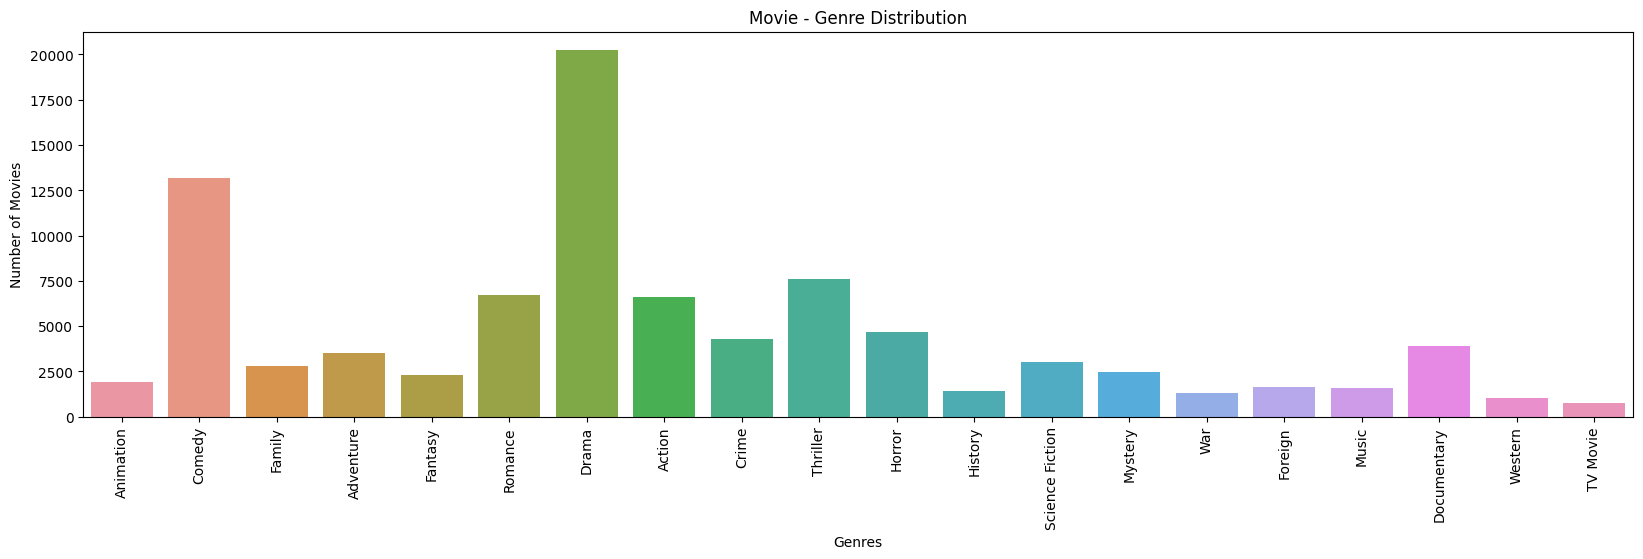

In [20]:
allGenreKeys = list(allGenres.keys())
allGenreValues = [int(i) for i in allGenres.values()]

plt.figure(figsize=(20, 5))
sb.barplot(x=allGenreKeys, y=allGenreValues)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.title('Movie - Genre Distribution')
plt.show()

Next up is the distribution of production companies that worked on movies in the dataset. This visualization shows us that a large amount of movies in this dataset are made by big Hollywood production companies such as `Warner Brothers`, `Disney` and `Century Fox`. Furthermore, it shows us that a large amount of smaller studios, such as `Silver Pictures`, `New Regency` and `Morgan Creek Productions`, have only a small amount of produced movies present in the dataset. From this, we can tell that `users have a bias towards blockbuster movies made by bigger studios`.

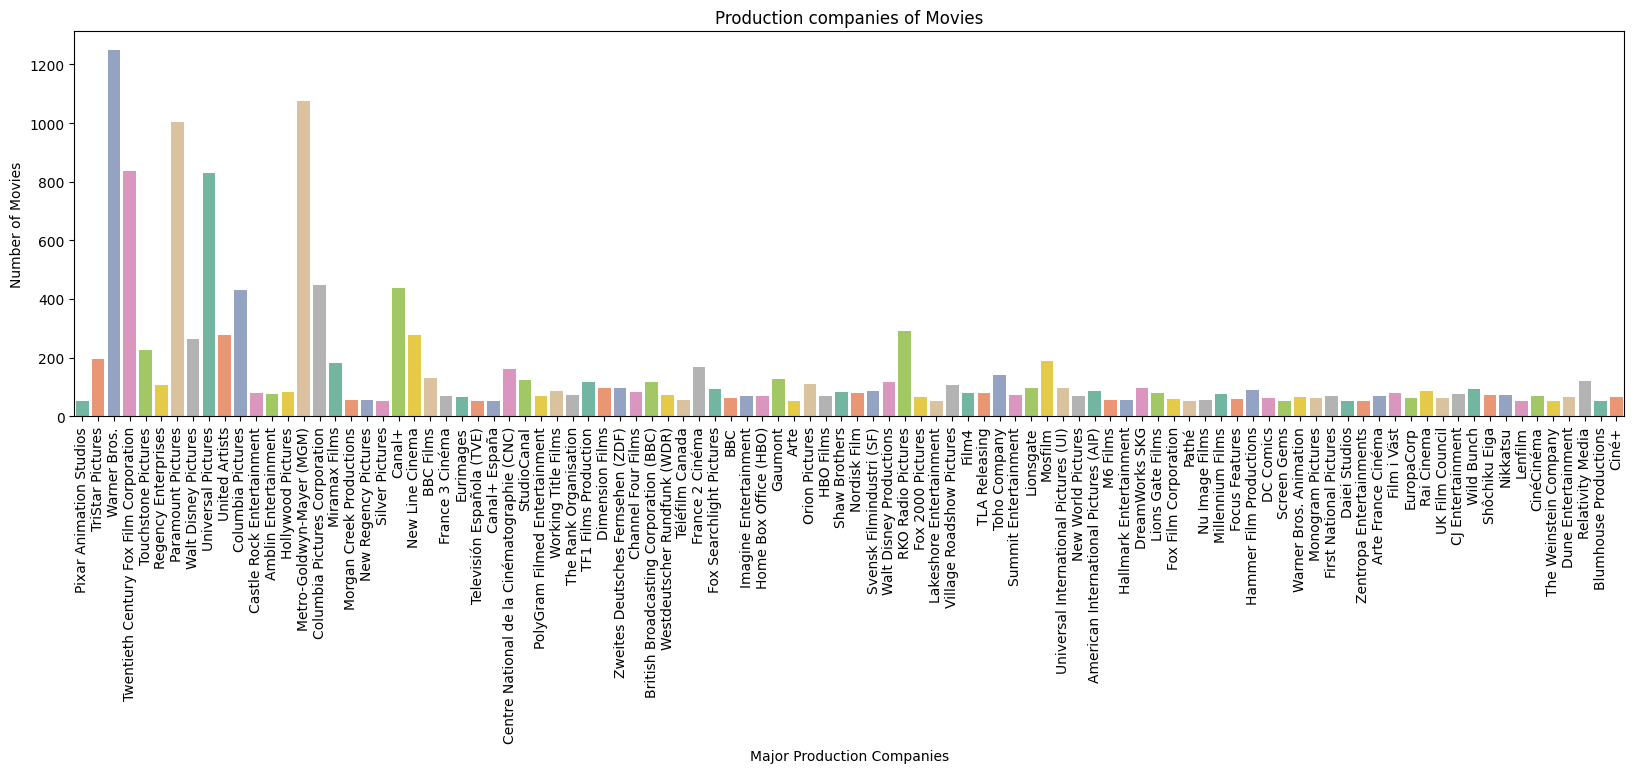

In [21]:
productionCompanyKeys = list(majorProductionCompany.keys())
productionCompanyValues = [int(i) for i in majorProductionCompany.values()]

plt.figure(figsize=(20, 5))
sb.barplot(x=productionCompanyKeys, y=productionCompanyValues, palette="Set2")
plt.xticks(rotation=90)
plt.xlabel('Major Production Companies')
plt.ylabel('Number of Movies')
plt.title('Production companies of Movies')
plt.show()

Next up, we will be looking at the distribution of movies released in each year. This visualization shows us that, `as we get closer to the current date, the amount of movies that are released each year is steadily increasing`. This represents the increasing demand for movies throughout the years, `increasing drastically as we enter the digital era in the late 90's` and peaking at 2015 in this set. It also demonstrates that `the majority of movies contained in this set are released between 2000 and 2017, potentially signifying a slight bias towards new movies`.

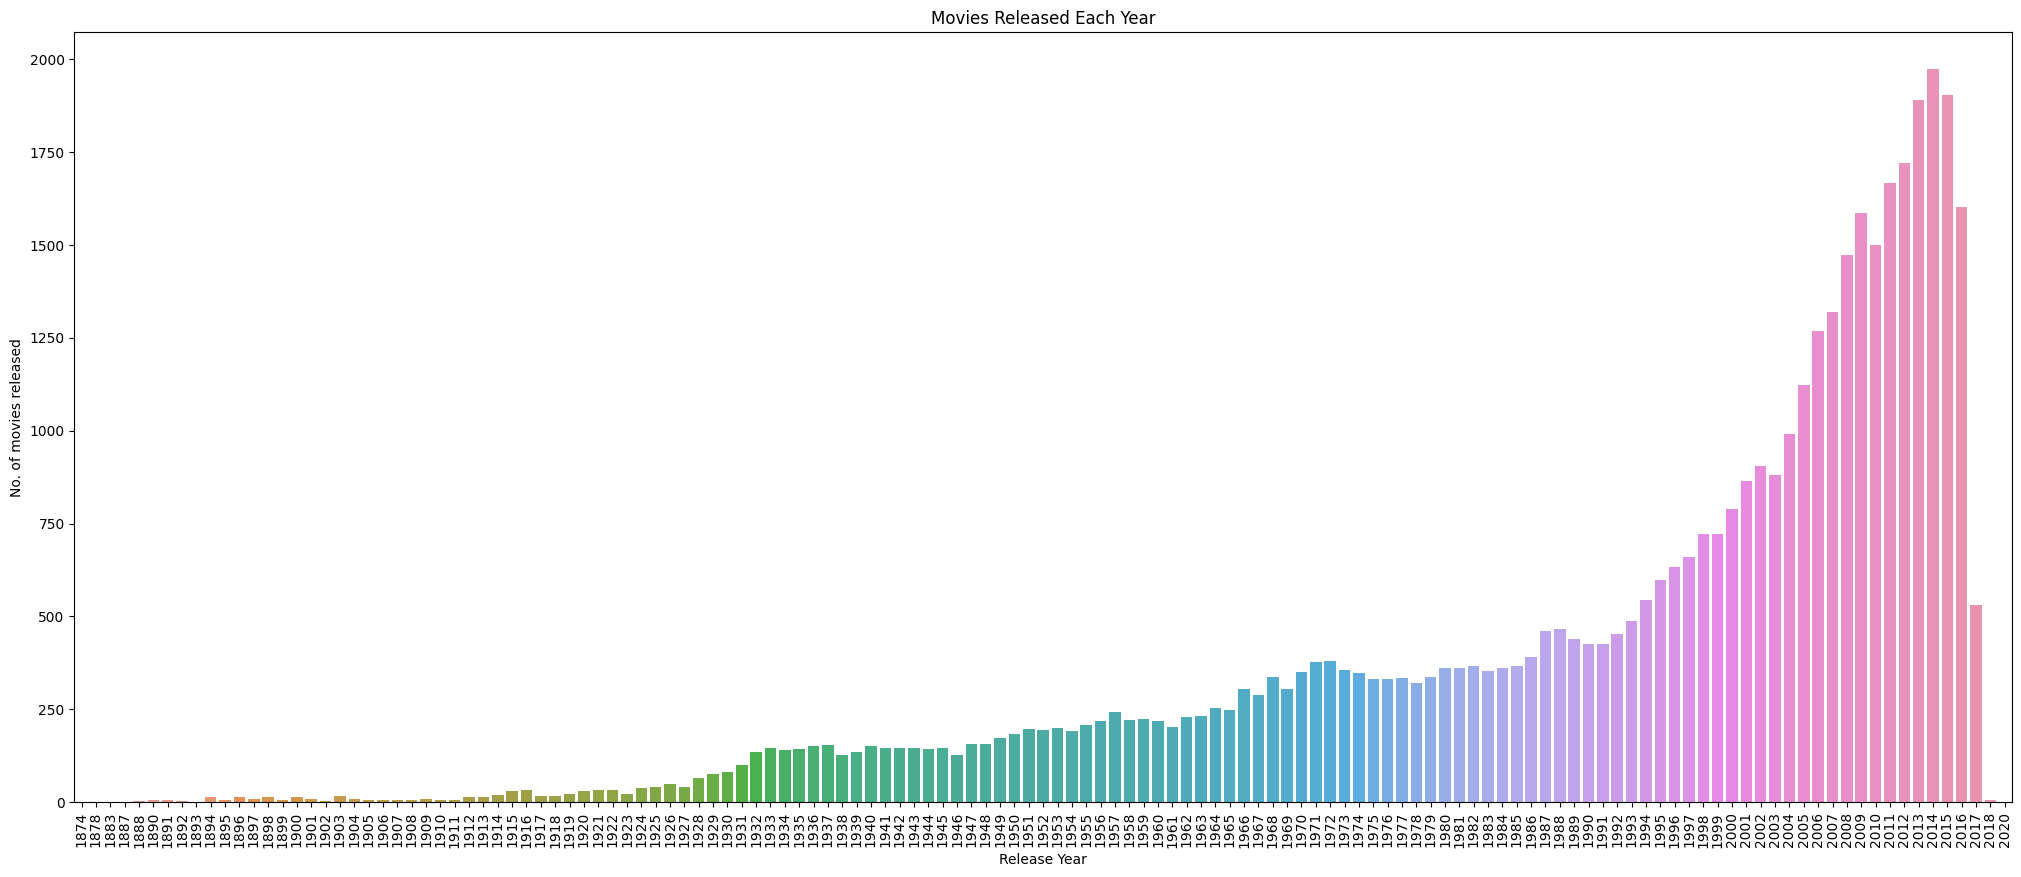

In [22]:
productionYear = movies['release_year'].value_counts().index.tolist()
yearlyReleases = movies['release_year'].value_counts().tolist()

plt.figure(figsize=(25, 10))
sb.barplot(x=productionYear, y=yearlyReleases)
plt.xticks(rotation=90)
plt.xlabel('Release Year')
plt.ylabel('No. of movies released')
plt.title('Movies Released Each Year')
plt.show()

Next up, we will be looking at the languages in which movies were released. This visualization shows us that there is `a large number of languages included in the dataset, with more common languages such as French, Italian, Japanese, German and Russian being more common than most other languages`. Furthermore, we see that `there is a major bias towards the English language`, which can be attributed to it being spoken in most countries around the world. From a modeling and recommendation standpoint, `this means that most recommended movies will be either dubbed in English, or produced by US production studios`.

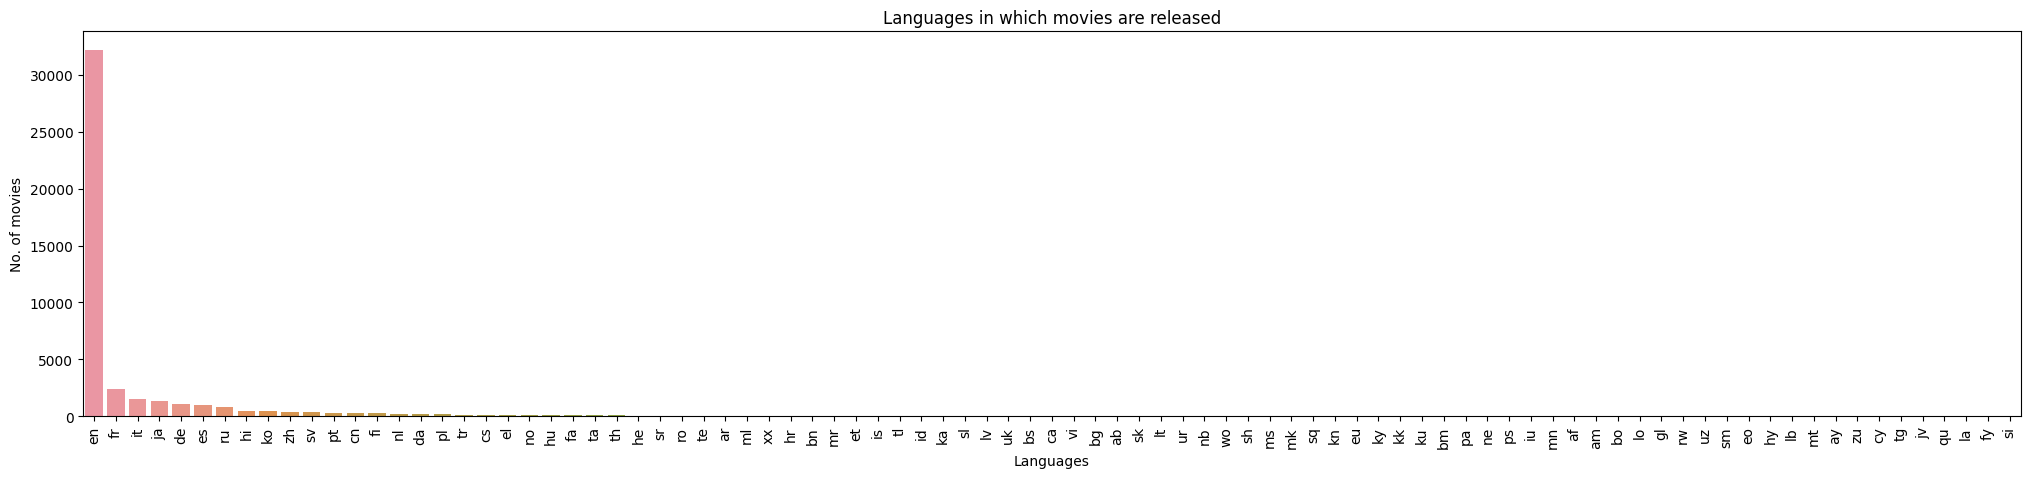

In [23]:
languages = movies['original_language'].value_counts().index.tolist()
moviesWithLanguage = movies['original_language'].value_counts().tolist()

plt.figure(figsize=(25, 5))
sb.barplot(x=languages, y=moviesWithLanguage)
plt.xticks(rotation=90)
plt.xlabel('Languages')
plt.ylabel('No. of movies')
plt.title('Languages in which movies are released')
plt.show()

Next up, we will be looking at the countries in which movies were produced. This visualization tells us that there is a large amount of countries in which movies present in this dataset are shot, with the `United Kingdom`, `Germany`, `Fance`, `Italia`, `Canada` and `Japan` being more common. Furthermore, we can see that `the vast majority of movies has been shot in the United States, which could indicate bias from the production companies towards shooting movies on home soil instead of other countries`.

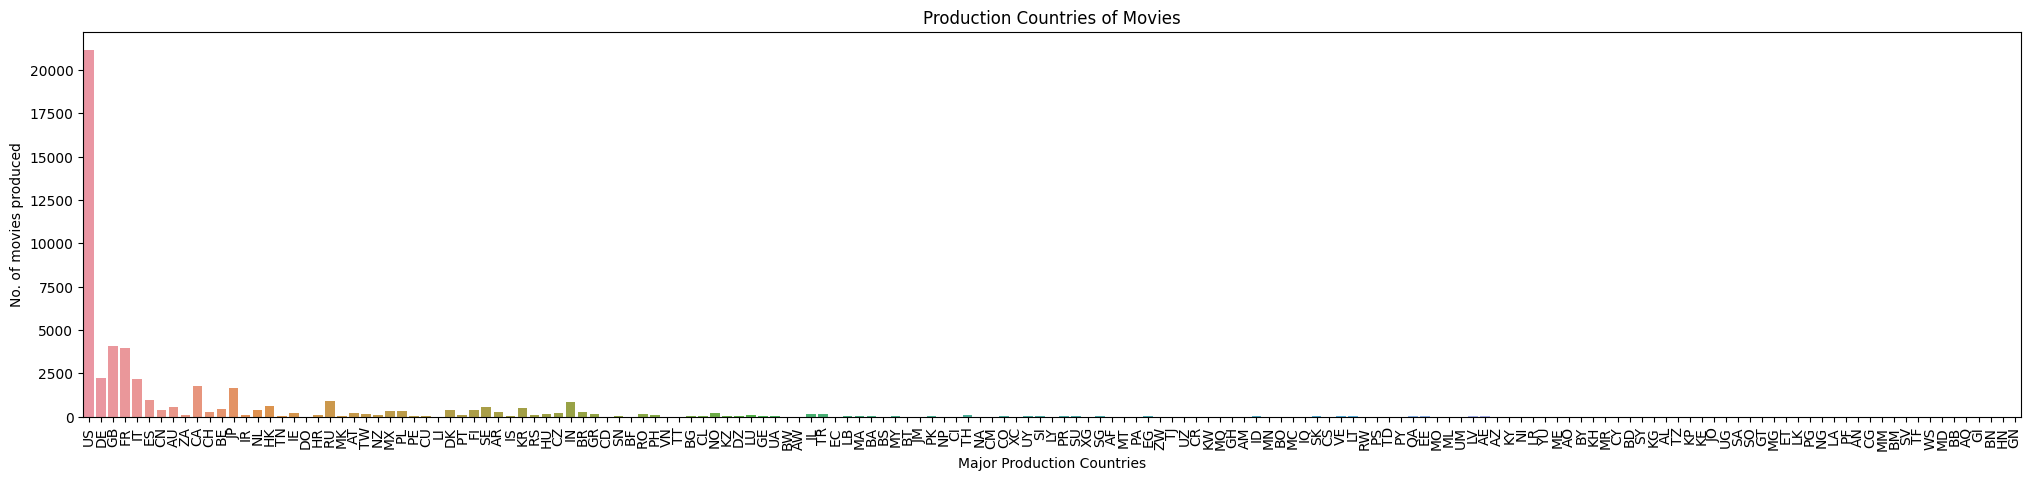

In [24]:
coountryKeys = list(allCountries.keys())
coountryValues = [int(i) for i in allCountries.values()]

plt.figure(figsize=(25, 5))
sb.barplot(x=coountryKeys, y=coountryValues)
plt.xticks(rotation=90)
plt.xlabel('Major Production Countries')
plt.ylabel('No. of movies produced')
plt.title('Production Countries of Movies')
plt.show()

Next up, we will be looking at the amount of revenue obtained from movies each year. This visualization shows us that `the timeline of revenue collected from movies released during years before 1970 is highly chaotic`. This can be attributed to a number of factors, such as `major world events`, `more primitive and limited access to technology` and `missing revenue data`. Furthermore, we can see that, from 1970 onwards, the revenue for movies gradually increases, spiking in 2017. This could be attributed to `movies becoming gradually more mainstream and easier to access, thanks to renting/streaming services`.

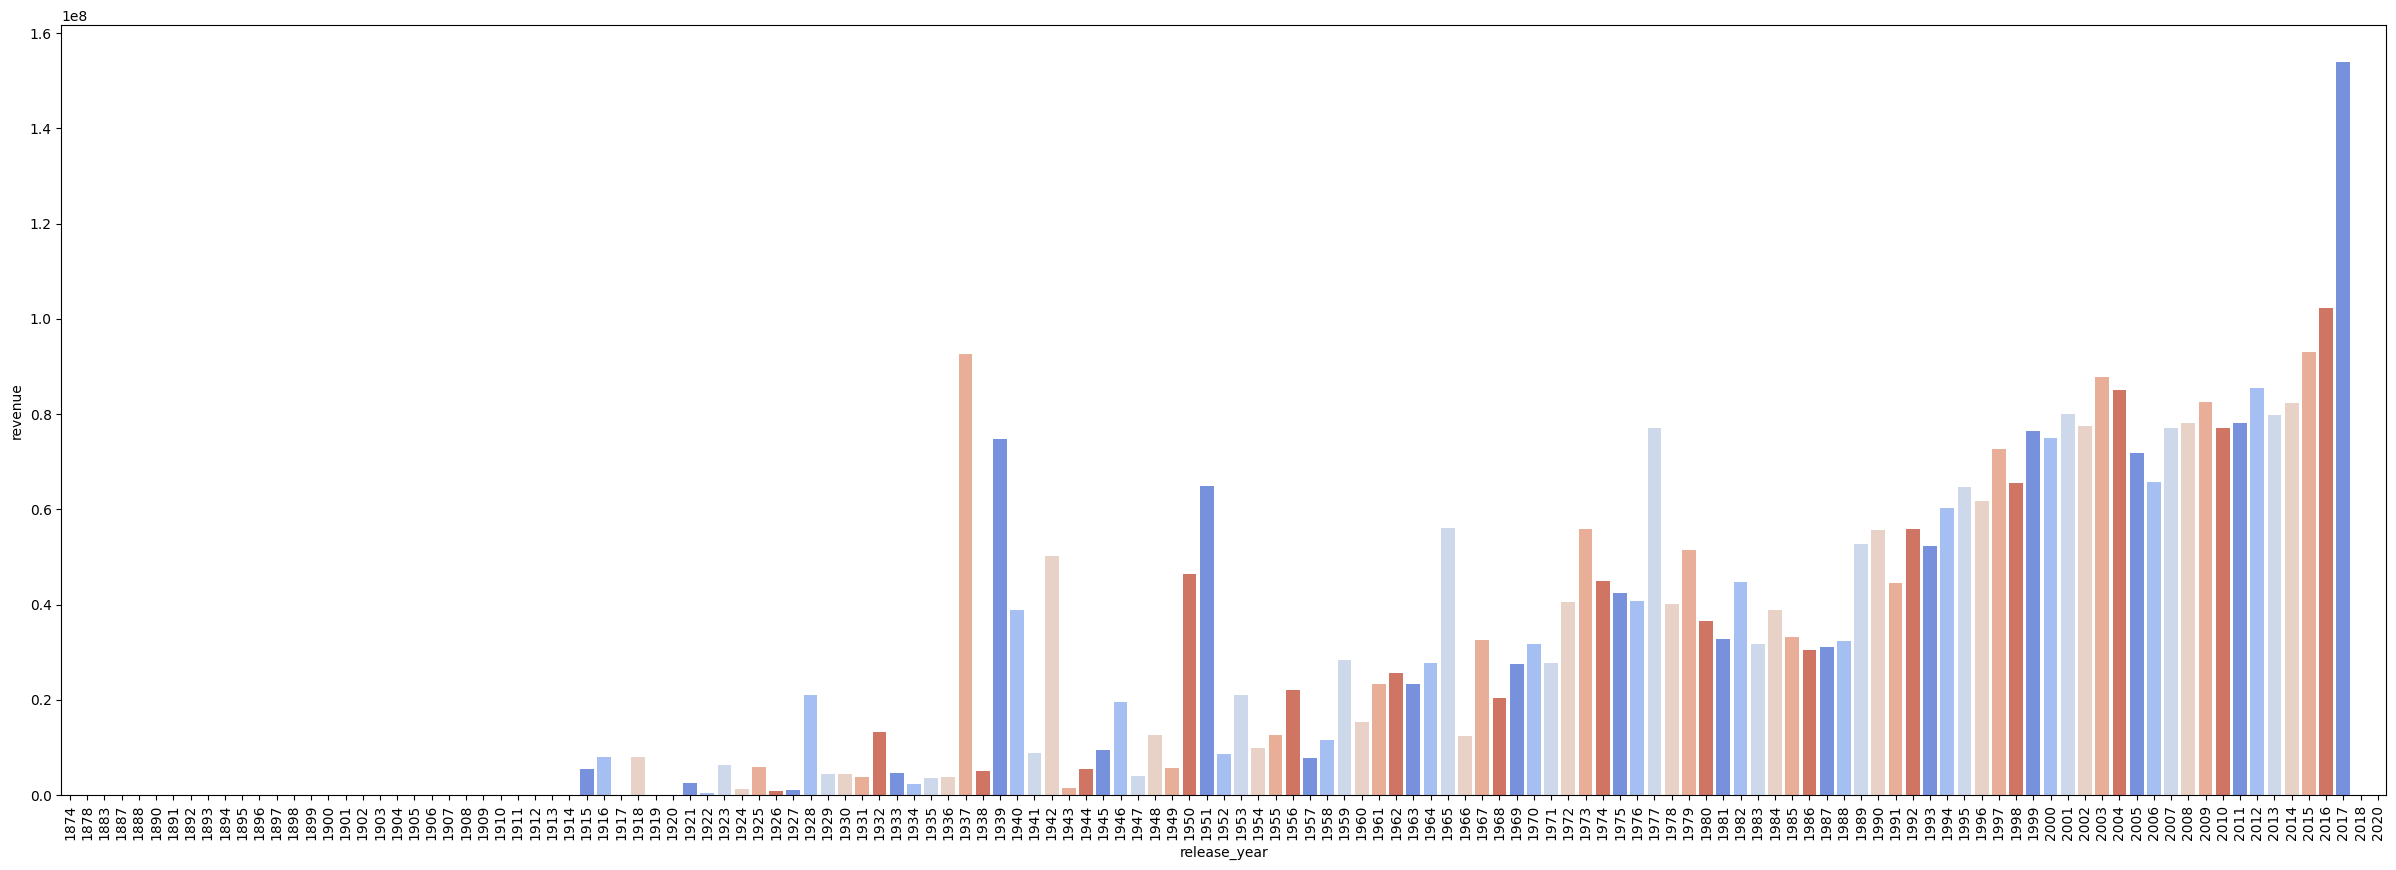

In [25]:
plt.figure(figsize=(30, 10))
sb.barplot(data=movies, x='release_year', y='revenue', errorbar=None, palette=sb.color_palette("coolwarm"))
plt.xticks(rotation=90)
plt.show()

Next, we will be taking a closer look at the revenue, for the top 20 movies with the highest amount of revenue in particular. This visualization shows us that all of titles with the most revenue are blockbuster movies shot by big Hollywood studios, further reinforcing the assumption that the majority of movie reviews are for blockbuster movies.

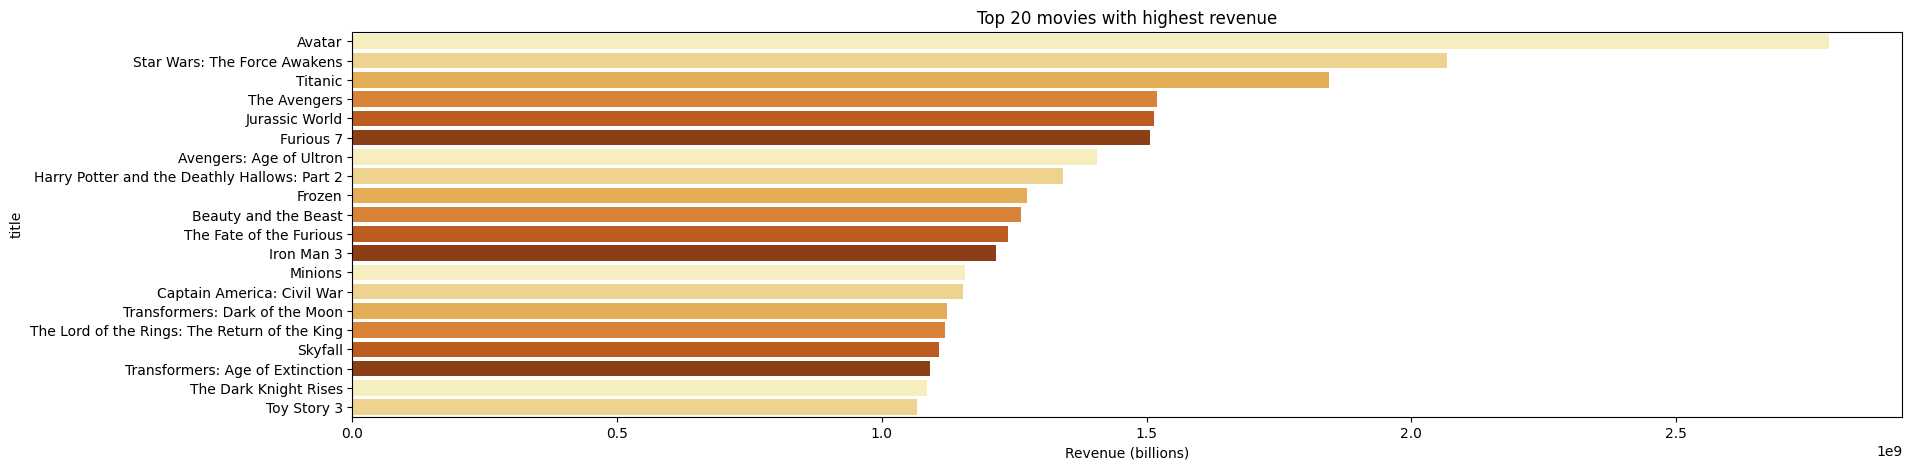

In [26]:
top20Revenue = movies.sort_values(by='revenue', ascending=False).iloc[:20][['title', 'revenue', 'release_year']]

plt.figure(figsize=(20, 5))
sb.barplot(y=top20Revenue['title'], x=top20Revenue['revenue'], errorbar=None, palette=sb.color_palette("YlOrBr"))
plt.xlabel('Revenue (billions)')
plt.title('Top 20 movies with highest revenue')
plt.show()

Next, we will be looking at the top 20 movies that had the biggest budget during production. This visualization shows us that, once again, all movies listed are blockbuster movies made by big Hollywood studios.

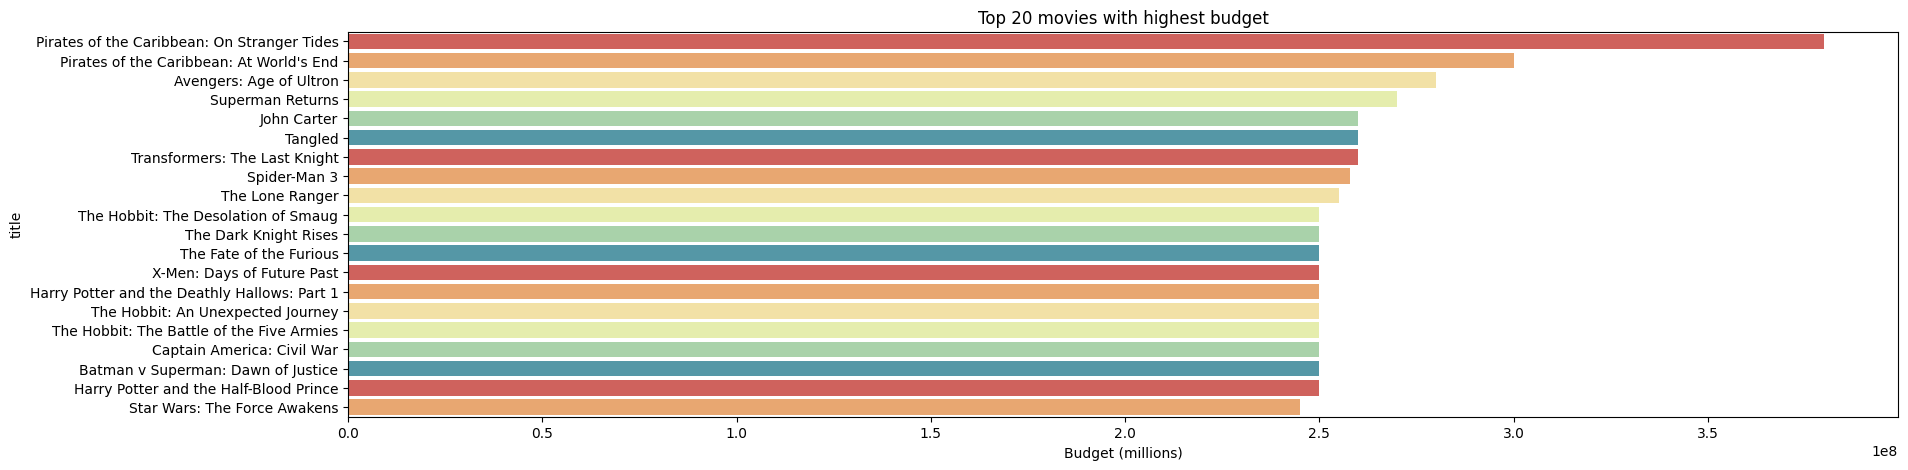

In [27]:
top20Budget = movies.sort_values(by='budget', ascending=False).iloc[:20][['title', 'budget', 'release_year']]

plt.figure(figsize=(20, 5))
sb.barplot(y=top20Budget['title'], x=top20Budget['budget'], errorbar=None, palette=sb.color_palette("Spectral"))
plt.xlabel('Budget (millions)')
plt.title('Top 20 movies with highest budget')
plt.show()

Next, we will be looking at the actors that have played in the movies listed in this dataset, and the amount of movies they appeared in. This visualization shows us that most actors appeared between between 50 and 100 movies, with `Samuel L. Jackson`, `Cristopher Lee` and `Bess Flowers` being outliers. This suggests these three actors were `popular casts by movie directors`, and are also `popular actors amongst the movie watchers`.

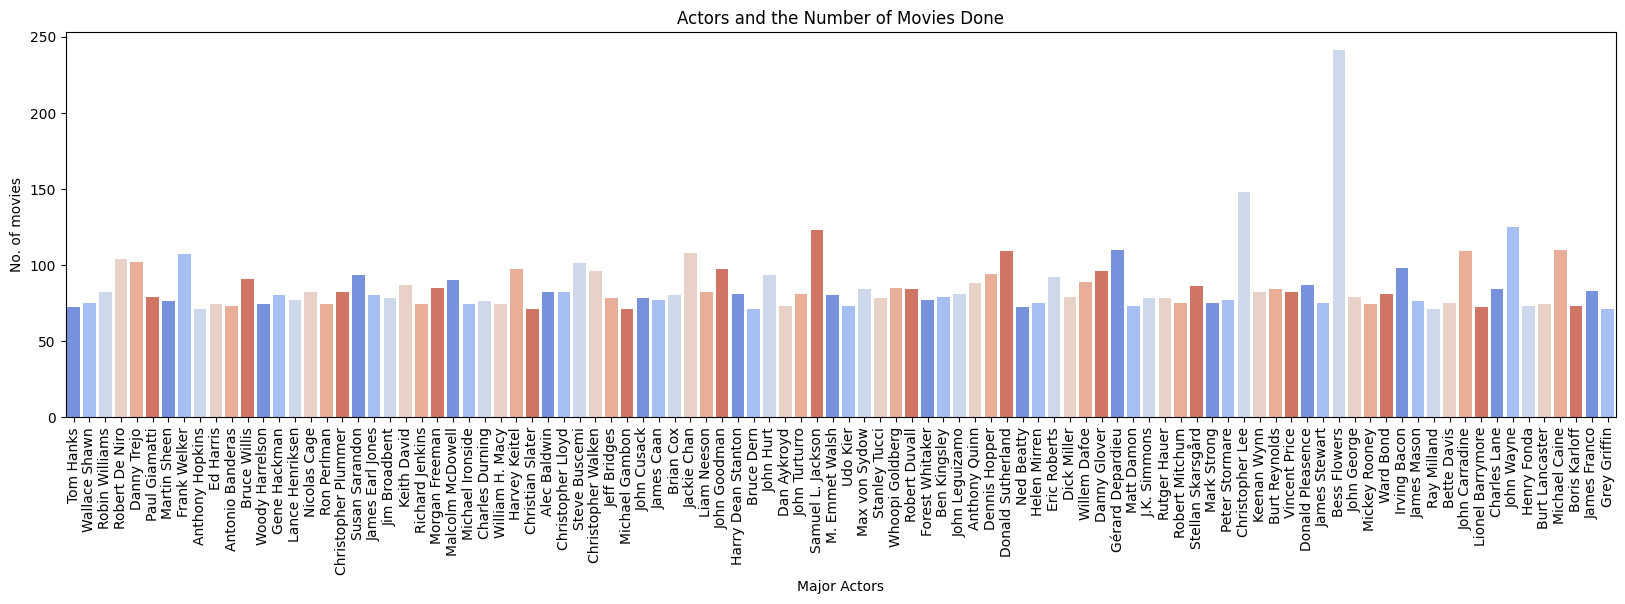

In [28]:
# Get the number of movies done by each actor
actors = getAll(df, 'casting')
actors = {k: v for (k, v) in actors.items() if v > 70}

plt.figure(figsize=(20, 5))
actor_keys = list(actors.keys())
actor_values = [int(i) for i in actors.values()]
sb.barplot(x=actor_keys, y=actor_values, palette=sb.color_palette("coolwarm"))
plt.xticks(rotation=90)
plt.xlabel('Major Actors')
plt.ylabel('No. of movies')
plt.title('Actors and the Number of Movies Done')
plt.show()

Finally, we will be looking at directors, and the amount of movies present in the dataset that they directed. This visualization shows us that `the majority of directors have directed between 30 and 40 movies, with a small number having directed between 40 and 50 movies`. Furthermore, it shows us that `Werner Herzog`, `Michael Curtiz` and `John Ford` were most often the director for movies in this dataset, `suggesting watchers may bias towards movies directed by these directors`.

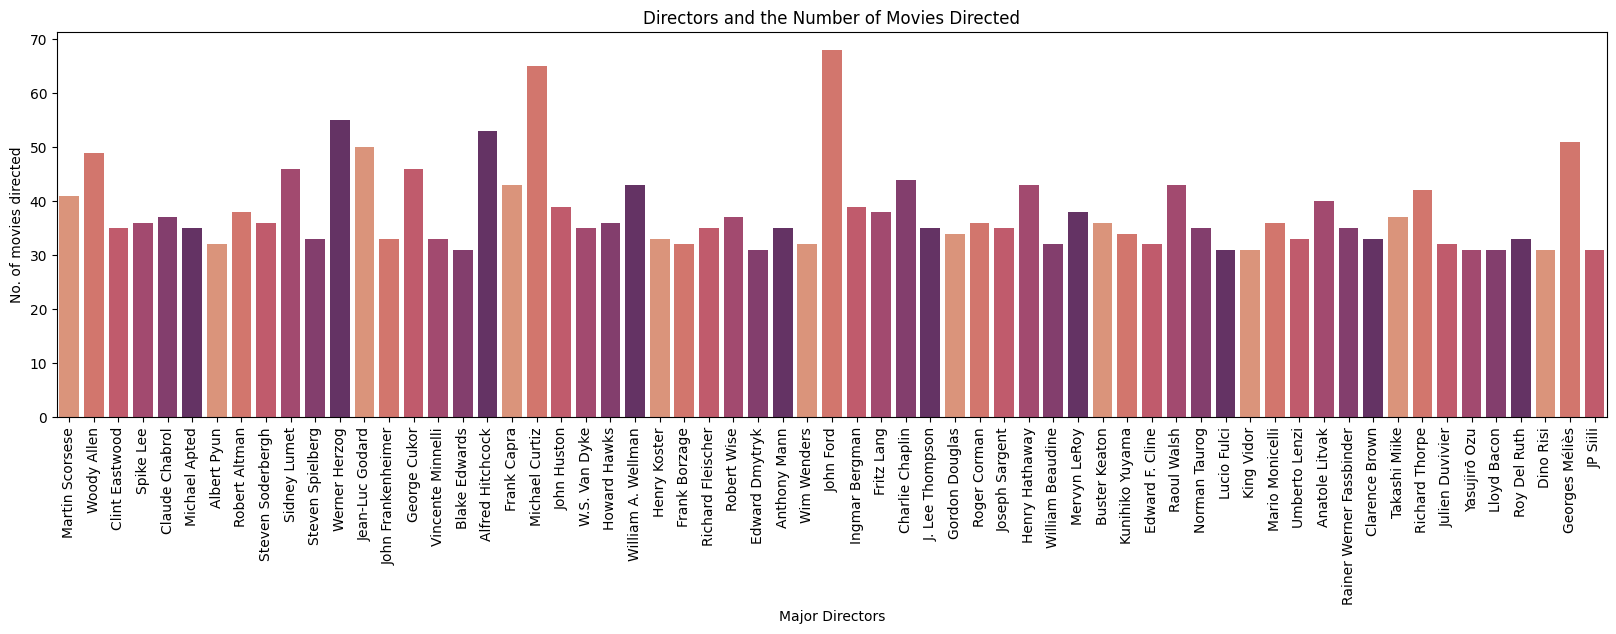

In [29]:
# Get the number of movies directed by each director
director = getAll(df, 'director')
director = {k: v for (k, v) in director.items() if v > 30}

plt.figure(figsize=(20, 5))
dir_keys = list(director.keys())
dir_values = [int(i) for i in director.values()]
sb.barplot(x=dir_keys, y=dir_values, palette=sb.color_palette("flare"))
plt.xticks(rotation=90)
plt.xlabel('Major Directors')
plt.ylabel('No. of movies directed')
plt.title('Directors and the Number of Movies Directed')
plt.show()

Looking at the data present in the dataset in various ways, we can safely say that the reviews in this dataset have a bias towards blockbuster movies made by large Hollywood studios. The vast majority of movies were shot in the US, which suggests the dataset has a bias towards movies from US studios. Furthermore, movies present in the dataset are largely from the modern era, and mostly dubbed in the English language, which could have an impact on predictions later during the modeling phase. 

After visuaizing the data and coming to the conlusions about what this data represents, I can see that there is more bias than I initially expected in the [Data Sourcing](#data-sourcing) section of this notebook. I did not realize there could be bias intoduced by variables that do not directly have anything to do with the user, examples of this being the inclusion of many blockbuster movies, most movies being produced in the US by big Hollywood studios and the user's tendency to watch those.

<hr/>

# Phase 3

# Pre Processing

In [30]:
del credits, keywords, movies, ratings, links, df
gc.collect()

77082

We'll start off by re-importing the datasets.

In [31]:
credits = pd.read_csv('./assets/tmds/credits.csv')
keywords = pd.read_csv('./assets/tmds/keywords.csv')
movies = pd.read_csv('./assets/tmds/movies_metadata.csv').drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).drop([19730, 29503, 35587]) # Incorrect data type
ratings_df = pd.read_csv('./assets/tmds/ratings_small.csv')
links = pd.read_csv('./assets/tmds/links.csv')

We'll now define a function called `getText()` that we're going to be using later in code. `getText()` will allow for extracting specific values of interest from these text objects.  

This function works as follows:
- `Converts the input text parameter into a Python object` using the [literal_eval()](https://docs.python.org/3/library/ast.html) function. It then evaluates the text as a Python expression and `returns the corresponding object`.
- The `if statement` checks if the length of the text object is equal to 1, meaning `there is only one item in the text list`.
- If there is `only one item in the text list`, the function then `returns the value of the specified` `obj` `attribute for that item`.
- Else, the code will `joins together the values of the specified obj` attribute for each item in the text list, separated by commas.

In [32]:
def getText(text, obj='name'):
    # Convert the input text to a Python object using literal_eval
    text = literal_eval(text)
    
    if len(text) == 1:
        # If there is only one item in the text list, return the value of the specified object
        return text[0][obj]
    else:
        # If there are multiple items in the text list, extract the values of the specified object for each item
        # and join them together with a comma separator
        return ', '.join([i[obj] for i in text])

First, we convert the `'id'` column in the `'movies'` DataFrame to 'int64'. Converting this column to the appropriate data type ensures consistency and compatibility.

Next, we merge the `'movies', 'keywords', and 'credits'` DataFrames based on the 'id' column. We'll be doing this, since this dataframe will be used through the pre-processing step.

Following that, we'll be `filling the missing values` in the `'original_language', 'runtime' and 'tagline'` column of the previously merged DataFrame. It uses the [fillna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) method to replace any `missing values` with either an `empty string or with 0`, thus, by filling missing values in specific columns we ensure data completeness and integrity.

This line drops rows with any missing values in the DataFrame using [dropna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) method, thus helping to remove incomplete or unreliable observations.

In [33]:
# Convert the 'id' column in the 'movies' DataFrame to 'int64' data type
movies['id'] = movies['id'].astype('int64')

# Merge the 'movies', 'keywords', and 'credits' DataFrames on the 'id' column
df = movies.merge(keywords, on='id').merge(credits, on='id')

# Fill missing values in the 'original_language', 'runtime', and 'tagline' columns
df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

# Drop rows with any missing values in the DataFrame
df.dropna(inplace=True)

These operations contribute to the data pre-processing process by extracting relevant information from specific columns, creating new columns to store the extracted data, and removing redundant or unnecessary columns. We first start off by applying the previously defined `getText()` function to the 'genres' column of the DataFrame. We then [apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) a function to each element in the column. In this case, `getText()` extracts the `'genres'` column. 

Similarly, `getText()` function is applied to the `'production_companies', 'production_countries', 'crew', 'spoken_languages', 'keywords' and 'actors' columns`, `extracting values` and converting it into a string, thus `making the values easier to read`. The use of the `getText()` function allows for extraction of information based on the specific columns they're applied to, helping to clean and organize the data within these columns.

Next up, this line `drops duplicate rows` from the DataFrame based on the `'original_title'` column. The [duplicated()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) method identifies duplicate rows, and `~` negates the boolean values, `selecting only the non-duplicate rows`. 

Finally, we reset the index of the DataFrame after dropping duplicates, thus ensuring integrity of the data, and avoiding index-based errors.

In [34]:
# Apply the 'getText' function to extract values from the 'genres', 'production_companies',
# 'production_countries', 'crew', 'spoken_languages', and 'keywords' columns
df['genres'] = df['genres'].apply(getText)
df['production_companies'] = df['production_companies'].apply(getText)
df['production_countries'] = df['production_countries'].apply(getText)
df['crew'] = df['crew'].apply(getText)
df['spoken_languages'] = df['spoken_languages'].apply(getText)
df['keywords'] = df['keywords'].apply(getText)

# Apply the 'getText' function to extract values from the 'cast' column
# and create new columns 'characters' and 'actors'
df['characters'] = df['cast'].apply(getText, obj='character')
df['actors'] = df['cast'].apply(getText)

# Drop the 'cast' column from the DataFrame
df.drop('cast', axis=1, inplace=True)

# Drop duplicate rows based on the 'original_title' column
df = df[~df['original_title'].duplicated()]

# Reset the index of the DataFrame after dropping duplicates
df = df.reset_index(drop=True)

We'll continue the pre-processing step with working on the df DataFrame. By converting `'release_date' to datetime format`, it becomes `easier to work with temporal data` and perform date-based operations. Converting `'budget' and 'popularity' to 'float64'` data types `ensures that these columns are ready for numerical calculations and analysis`. 

In [35]:
# Convert the 'release_date' column to datetime format
df['release_date'] = pd.to_datetime(df['release_date'])

# Convert the 'budget' column to 'float64' data type
df['budget'] = df['budget'].astype('float64')

# Convert the 'popularity' column to 'float64' data type
df['popularity'] = df['popularity'].astype('float64')

pd.set_option('display.max_columns', None)
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000.0,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,1995-12-15,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,1995-12-22,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000.0,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0.0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,1995-02-10,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


The operations below contribute to the data pre-processing process by `converting timestamps to datetime objects`, `merging relevant columns from different DataFrames` and `handling missing values`. These choices are made in order to create a more `consolidated DataFrame` that `contains the necessary information` for further modeling tasks.

In [36]:
# Convert the 'timestamp' column to a datetime object using the 'fromtimestamp' method
ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

# Drop the 'timestamp' column from the DataFrame
ratings_df.drop('timestamp', axis=1, inplace=True)

# Merge the 'ratings_df' DataFrame with the selected columns from the 'df' DataFrame based on matching 'movieId' and 'id'
ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']],left_on='movieId', right_on='id', how='left')

# Drop rows with missing values in the 'id' column
ratings_df = ratings_df[~ratings_df['id'].isna()]

# Drop the 'id' column from the DataFrame
ratings_df.drop('id', axis=1, inplace=True)

# Reset the index of the DataFrame
ratings_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the DataFrame
ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-14 03:52:15,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-14 03:53:23,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-14 03:52:19,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-14 03:53:18,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-14 03:51:48,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [37]:
# Select the 'id' and 'original_title' columns from the 'df' DataFrame
movies_df = df[['id', 'original_title']]

# Rename the 'id' column to 'movieId'
movies_df.rename(columns={'id': 'movieId'}, inplace=True)

# Display the first few rows of the DataFrame
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


For the forthcoming modeling stage, we start off by creating TensorFlow datasets from the previously processed dataframes, in the form of `ratings` and `movies`. The sets are then mapped using the [map()](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) function, this way ensuring we have the right data types and only the columns we want to include for training. We will be using said sets throughout the entirety of the modeling process. I opted to use `'original_title', 'userId' and 'rating'` for the sole reason of performance.  

In [38]:
# Convert the 'userId' column to string data type
ratings_df['userId'] = ratings_df['userId'].astype(str)

# Create a TensorFlow Dataset from the selected columns in the ratings_df DataFrame
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))

# Create a TensorFlow Dataset from the 'original_title' column in the movies_df DataFrame
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

# Map the ratings Dataset to transform the data types and select specific columns
ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

# Map the movies Dataset to select the 'original_title' column
movies = movies.map(lambda x: x["original_title"])

input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
components_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
components_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
components_2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device

Next up, we'll be looking at the amount of data we're working with, in our case, looking at the number of data points contained the dataset. It might be a little hard to spot across all of these logs, but our total data points are at `43188`. We thsen continue with shuffling the dataset and creating a train and test split of the data. The random seed is set for reproducibility, making sure that the same shuffling and dataset splitting can be replicated in future runs of the code. 

In [39]:
# Print the total number of data points in the 'ratings' dataset
print('Total Data: {}'.format(len(ratings)))

# Set the random seed for reproducibility
tf.random.set_seed(42)

# Shuffle the 'ratings' dataset
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

# Create a training dataset by taking a subset of the shuffled dataset
train = shuffled.take(25_000)

# Create a test dataset by skipping the first 25,000 data points and taking the next 8000 data points
test = shuffled.skip(25_000).take(8_000)

input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
DatasetCardinality: (DatasetCardinality): /job:localhost/replica:0/task:0/device:CPU:0
cardinality_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Total Data: 43188
input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
x: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
y: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
Equal: (Equal): /job:localhost/replica:0/task:0/device:CPU:0
z_RetVal: (_Retval): /job:localhost/replica:0/

Following that, we'll be looking at the `unique numbers of movies and users`. This will be especially useful after the model is trained, since we'll be able to know how many users we're going to be working with for recommendations and predictions. Once again, due to TensorFlow's output, it's pretty difficult to spot the exact datapoints. From the output, we can see that we have `42373 unique movies` and `671 unique users`.

In [40]:
# Batch the 'movies' dataset with a batch size of 1,000
movie_titles = movies.batch(1_000)

# Batch the 'ratings' dataset with a batch size of 1,000 and extract the 'userId' column
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

# Concatenate the batches of 'movie_titles' dataset to get unique movie titles
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))

# Concatenate the batches of 'user_ids' dataset to get unique user IDs
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# Print the number of unique movie titles
print('Unique Movies: {}'.format(len(unique_movie_titles)))

# Print the number of unique user IDs
print('Unique users: {}'.format(len(unique_user_ids)))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
batch__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
drop__remainder: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
BatchDatasetV2: (BatchDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
batch__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
drop__remainder: (_Arg): /job:localhost/replica:0/task:0/device

# Modeling

It's time to define the actual `MovieModel` class. The core architecture of this class revolves around [TFRS](https://www.tensorflow.org/recommenders) `(TensorFlow Recommenders)`. This class incorporates `movie and user embeddings`, a rating model, and ranking and retrieval tasks. It `takes input features`, `computes embeddings`, `predicts ratings`, and `computes the loss for training the model`. Let's go in depth and analyze what this class does, and why the choices were made to make it like this:

The constructor of the `MovieModel` class takes two parameters: `rating_weight` and `retrieval_weight`. These weights determine the relative importance of the `rating prediction task` and the `retrieval task` in the `overall loss calculation`. By allowing different weights to be passed, the model `can be trained with different emphasis on these tasks`. The weight values are defined as floats, therefore we can set different values and expect to get different results. `Weights are especially important` in an ML sense, since said weights `set the standards` for the `neuron’s signal strength`. This value will determine the `influence that the input data has on the model's output`. What is a `neuron` in this context you may ask? In the context of a neural network, a neuron is the most fundamental unit of processing. `Neural networks are based on the way a human brain works`. So, we can say that it `simulates the way the biological neurons signal to one another`.

The `embedding dimension is set to 64`. `Embeddings are lower-dimensional representations of categorical variables`, in our case, `movie titles and user IDs` that capture their `semantic meaning`. A lower-dimensional representation helps in `capturing relevant features` and `reducing computational complexity`. You may again ask what `semantics` are? In the context of machine learning, `semantics refer to the meaning or interpretation of words, phrases, sentences, or other units of language`. It is concerned with `understanding the relationships and associations between different linguistic elements and how they convey meaning`. For example, in the class below, `semantics` `deal with movie titles and user IDs`. By using embeddings, the model `aims to learn lower-dimensional representations` that capture the semantic meaning of these categorical variables. Instead of `treating movie titles and user IDs` as `arbitrary labels`, `the model maps them to dense vectors in an embedding space`, where the distances between embeddings reflect their semantic similarities. For another example, the `StringLookup` layer in the model `maps movie titles to unique integer IDs`. This mapping is `not random` but is `based on the semantic similarity between movie titles`. `Movies with similar titles are likely to have embeddings that are closer to each other in the embedding space`, indicating their `semantic similarity`.

The `movie_model` is defined as a [keras Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). This consists of two layers: a `StringLookup` layer followed by an `Embedding` layer. The `StringLookup layer maps the movie titles to unique integer IDs`, and the `Embedding layer learns the embeddings of the movie titles`. This model is used to encode movie information. The `user_model` is defined in a similar manner, this taking `user IDs as input and learns the embeddings for the users`.  

The `rating_model` is a small neural network, again defined as a [keras Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). It consists of `three dense layers with ReLU activation functions`. ReLU, or Rectified Linear Unit(s) are short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance. Here are a couple reasons why we're gonna be using it in this model:

1. `Non-linearity`: ReLU `introduces non-linearity to the network`, allowing it to `learn and represent more complex relationships between the input features`. The activation function `transforms the output of a neuron` by `mapping negative values to zero and leaving positive values unchanged`. The non-linearity aspect enables the model to `capture non-linear patterns in the data`, which is often `necessary for complex tasks like movie rating prediction`.
2. `Sparse activation`: ReLU has a `sparse activation property`, meaning that it tends to `activate only a subset of neurons` in a layer while `keeping others inactive`. This sparsity can `help the model` in `learning more meaningful and selective representations of the data`. Sparse activation can be `beneficial when dealing with high-dimensional input spaces`, such as `movie embeddings`.
3. `Efficient computation`: ReLU is `efficiently implemented`, making it `faster to compute` compared to some other activation functions.

Continuing, the model `takes the concatenated user and movie embeddings as input` and `predicts a scalar rating for the movie`. The choice of a `multi-layered model allows for capturing complex relationships between user and movie features`.

Next up, we define `two tasks`: `rating_task` and `retrieval_task`. The `rating_task` is `used for rating prediction`, and the `retrieval_task` is used for `retrieving similar movies`. Different metrics are specified for each task, such as `RMSE for rating prediction` and `factorized top-k metric for retrieval`. The reason why we're using the top-k metric is as follows:

1. `Ranking-based evaluation`: In recommendation systems, the goal is often to `provide a ranked list of items that are most relevant to a user`. The `Factorized Top-K` metric `evaluates the model's ability` to `rank the true positive items`, such as relevant movies `higher than the false positive items`, in our case, those being irrelevant movies. It measures the `effectiveness of the retrieval task by focusing on the top-k items` in the ranked list, where `k represents the number of recommendations provided to the user`.
2. `Personalized recommendations`: Factorized Top-K `allows for personalized recommendations` by considering the `user embeddings learned by the model`. The metric takes into account the user's unique preferences and `aims to rank movies that are most likely to be of interest to the user higher in the retrieval list`.

The `compute_loss` method takes the `features` and `training` parameters as input. It computes the rating loss using the `rating_task` and the retrieval loss using `retrieval_task`. It returns the `combined loss`, weighted by the specified loss weights.

*Sources:*

*Bhargav, N. (2022, October 26). Neurons in neural networks. Baeldung on Computer Science.*

*https://www.baeldung.com/cs/neural-networks-neurons#:~:text=In%20the%20context%20of%20a,neurons%20signal%20to%20one%20another.*

*The University. (1978). What Is A Neural Network?. Amazon.*

*https://aws.amazon.com/what-is/neural-network/#:~:text=A%20neural%20network%20is%20a,that%20resembles%20the%20human%20brain.*

In [41]:
class MovieModel(tfrs.models.Model):
    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
        # We take the loss weights in the constructor: this allows us to instantiate
        # several model objects with different loss weights
        super().__init__()

        embedding_dimension = 64

        # User and movie models
        self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # A small model to take in user and movie embeddings and predict ratings
        
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # Tasks
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),            
            metrics=[
                tf.keras.metrics.RootMeanSquaredError(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC(),
            ],
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.movie_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["userId"])

        # And pick out the movie features and pass them into the movie model.
        movie_embeddings = self.movie_model(features["original_title"])

        return (
            user_embeddings,
            movie_embeddings,
            # We apply the multi-layered rating model to a concatenation of user and movie embeddings.
            self.rating_model(
                tf.concat([user_embeddings, movie_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        ratings = features.pop("rating")

        user_embeddings, movie_embeddings, rating_predictions = self(features)

        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

We'll now be moving to the training step.

We first define a `MovieModel` object with specified `rating_weight` and `retrieval_weight`, in our case `1.0` for each. These weights determine the relative importance of the rating prediction and retrieval tasks in the model's loss calculation. The choice of these weights can be adjusted depending on the desired emphasis on each task.

After, we define the optimizer. We'll be using `TensorFlow-Keras'` [Adagrad](https://keras.io/api/optimizers/adagrad/) algorithm with a learning rate of `0.1`. The optimizer is responsible for updating the model's parameters during the training process. `Adagrad is an optimization algorithm that adapts the learning rate for each parameter based on its past gradients`, which can be beneficial when dealing with sparse data or features.

We will then move on to preparing the train and test datasets. The `training` dataset is prepared by `shuffling the data` by `batching it into groups of 1000`, and caching it for `improved performance`. Data batching `improves training efficiency` by processing multiple samples simultaneously. The reason why I chose batches of `1000` was because I didn't want to overuse my available `VRAM, or GPU Memory`, since I only have around 4GB of memory to work with. In a similar fashion, the `test` set is prepared by `batching it into groups of 1000` and `caching it`. This allows for `efficient evaluation` of the model's performance on the test data.

It's finally time to train the model. We will be trainint it on `five epochs`, meaning the `entire training dataset is processed five times`. We'll also be using the `GPU` wherever possible. By using the `GPU` and in my particular case, `Metal acceleration`, we'll get `faster training times`, since we'll be relying on the `parallel processing capabilities` of the `GPU`.

In [42]:
# Check if GPU is available
if tf.test.is_gpu_available():
    print('GPU acceleration is Pedal to the Metal? (apple rizz).')
else:
    print('lmao no')

# Create a MovieModel object with specified rating and retrieval weights
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)

# Define the optimizer with a learning rate of 0.1 using Adagrad algorithm
optimizer = tf.keras.optimizers.Adagrad(0.1)

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer, metrics=[
    tf.keras.metrics.RootMeanSquaredError(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.AUC(),
])

# Prepare the training dataset by shuffling the data, batching it into groups of 1000, and caching it for improved performance
train_dataset = train.shuffle(100_000).batch(1_000).cache()

# Prepare the test dataset by batching it into groups of 1000 and caching it
test_dataset = test.batch(1_000).cache()

with tf.device("/gpu:0"):
    model.fit(train_dataset, epochs=5)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU acceleration is Pedal to the Metal? (apple rizz).
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
input: (_Arg): /jo

# Evaluation

We'll now start with evaluating the data. The code evaluates the trained model on the test dataset using the evaluate method. This process involves feeding the test dataset into the model and obtaining predictions for the given inputs. The evaluation is performed to assess the model's performance on unseen data and to obtain quantitative metrics that indicate how well the model is performing. 

*Disclaimer: For convenicence and readability's sake, we'll be printing the model metrics in the explanations below*

Let's go over the individual evaluation metrics and deep dive into the results.

1. `Retrieval Top-100 Accuracy`: This metric is extracted from the evaluation results using the key `'factorized_top_k/top_100_categorical_accuracy'`. It represents the accuracy of the model in retrieving the correct answer within the top 100 candidates. For a real-world example, in many recommendation systems, search engines, or information retrieval systems, users are presented with a limited number of options, often in a ranked order. Ensuring that the most relevant items are included within the top candidates is crucial for user satisfaction and engagement. Overall, this metric provides a measure of how well a model performs in retrieving relevant items within a limited set of candidates. In our model here, we can see that this metric yields pretty bad, but expected results, in the form of `"Retrieval top-100 accuracy: 0.161"`, which is basically in the low 10%. This however, can be imporoved, with changes to the codebase.
2. `RMSE (Root Mean Squared Error)`: The `RMSE` metric is a measure of the `average deviation between the predicted rankings or ratings` and the `true rankings or ratings`. It is commonly used to evaluate the performance of models in regression or ranking tasks. In our code, this metric represents the `average differences between the predicted rankings` and the `true rankings`. It's calculated by taking the square root of the mean of the squared differences between the predicted and true values. In our code, a value of `1.003 for RMSE` means that, on average, the predicted rankings or ratings `deviate from the true rankings or ratings by approximately 1.003 units`. The movies in this dataset are `rated from 1-5`, hence why this metric shows us that we're `~1 rating point off for every prediction made`, which is, once again, not great, but further optimizable.
3. `Precision`: The precision metric is a measure of the accuracy of a model's predictions, specifically in the context of positive predictions. It relates to the `proportion of correctly predicted positive samples` among zall the predicted positive samplesz. The importance of this metric lies in its role in zassessing the model's ability to avoid false positivesz, `high precision indicating that the model has a low rate of false positives`. This metric yields `a precision score of 1.000`, hence indicating that the predictions made are correct.
4. `Recall`: The recall metric is a `measure of the completeness of a model's predictions`. The importance of this metric lies in its role in assessing the model's ability to avoid false negatives. We got a score of `1.000`, hence telling us that that the model` has not missed or incorrectly classified any positive instances`. It suggests that all the actual positive samples have been correctly identified and included in the model's predictions.

In [43]:
# Evaluate the model on the test dataset and return the evaluation metrics as a dictionary
metrics = model.evaluate(test_dataset, return_dict=True)

# Extract and print the retrieval top-100 accuracy metric from the evaluation results
retrieval_accuracy = metrics['factorized_top_k/top_100_categorical_accuracy']
print(f"\nRetrieval top-100 accuracy: {retrieval_accuracy:.3f}")

# Extract and print the ranking RMSE metric from the evaluation results
ranking_rmse = metrics['root_mean_squared_error']
print(f"RMSE (Root Mean Squared Error): {ranking_rmse:.3f}")

precision = metrics['precision']
print(f"Precision: {precision:.3f}")

recall = metrics['recall']
print(f"Recall: {recall:.3f}")

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableO

Below, we'll be defining the main prediction functions for our model. The first one is `predictMovies` function is useful for `generating the movies index for a given user`. By using the `BruteForce index`, it allows for `efficient retrieval of recommendations based on user embeddings`. The choice of `BruteForce indexing can be practical for small to medium-sized datasets` or when the `recommendation task doesn't require real-time updates`. It provides a `straightforward way to retrieve top recommendations based on user input`.

The `predictRating` function is will be used for `predicting ratings for a specific movie for a given user`. It `utilizes the trained user and movie embeddings` and the `prediction model` to `generate a predicted rating`. This can be valuable in scenarios where personalized movie ratings need to be predicted for users, allowing for customized movie recommendations or user-specific analysis.

In [44]:
def predictMovies(user, top_n=3):
    # Create a model that takes in raw query features
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

    # Index the movies dataset for recommendations
    index.index_from_dataset(
        tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations
    _, titles = index(tf.constant([str(user)]))

    # Print the top recommendations for the user
    print(f"Top {top_n} recommendations for user {user}:\n")
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print(f"{i+1}. {title.decode('utf-8')}")

def predictRatings(user, movie):
    # Get the trained movie and user embeddings, and the predicted rating
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
        "userId": np.array([str(user)]),
        "original_title": np.array([movie])
    })
    
    # Print the predicted rating for the movie
    print(f"Predicted rating for {movie}: {predicted_rating.numpy()[0][0]}")

Here we will be predicting the first `10` movies for user `521`. Once again, `TensorFlow's` output makes it difficult to read, so I will put the recommendations for this user here, as a means of convenience.

1. Men in Black II
2. Sleepless in Seattle
3. License to Wed
4. Confession of a Child of the Century
5. The Talented Mr. Ripley
6. Rosemary's Baby
7. The Million Dollar Hotel
8. Finding Forrester
9. 英雄
10. 8 Mile

In [45]:
predictMovies(521, 10)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
other__arguments_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
other__arguments_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
other__arguments_2: (_Arg): /job:localhost/r

Following that, we will be `predicting ratings` for the `same user`, but this time for a `different, unrelated movie from the dataset`, in our case, `"The Terminal"`. I'll once again leave print the ratings here for the sake of convenience.

`Predicted rating for The Terminal: 0.7165935635566711`

The recommendations allows us to evaluate the model's performance in predicting ratings for a wide range of movies, including those that the `user hasn't interacted with before`. The predicted rating for "The Terminal" can be used to understand the `model's estimation of how well the user might rate this specific movie`. In this case, it's quickly apparent that this movie will probably `not be received well by this user`.

In [46]:
predictRatings(521,'The Terminal')

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LookupTableFindV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ResourceGather in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LookupTableFindV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
indices: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
ResourceGather: (ResourceGather): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
Ex

For referece, these are all the movies that `User 521` has rated in this dataset.

In [47]:
ratings_df[ratings_df['userId'] == '521']

,userId,movieId,rating,date,original_title,genres,overview
32579,521,236,3.5,2013-06-01 09:34:29,Muriel's Wedding,"Drama, Comedy, Romance",Muriel’s Wedding is P.J. Hogan’s film debut. A...
32580,521,260,4.5,2013-06-01 09:46:17,The 39 Steps,"Action, Thriller, Mystery","While on vacation in London, Canadian Richard ..."
32581,521,318,4.5,2013-06-01 09:40:53,The Million Dollar Hotel,"Drama, Thriller",The Million Dollar Hotel starts with a jump fr...
32582,521,333,3.5,2013-06-01 09:35:02,Bollywood/Hollywood,"Comedy, Drama, Music, Romance",Rahul Seth is a dashing young millionaire who ...
32583,521,471,3.5,2013-06-01 09:35:27,Bandyta,Drama,Bastard depicts the distress of needy children...
32584,521,527,4.5,2013-06-01 09:37:50,Once Were Warriors,Drama,A drama about a Maori family lving in Auckland...
32585,521,593,4.5,2013-06-01 09:46:44,Солярис,"Drama, Science Fiction, Adventure, Mystery",Ground control has been receiving strange tran...
32586,521,608,5.0,2013-06-01 09:49:28,Men in Black II,"Action, Adventure, Comedy, Science Fiction","Kay and Jay reunite to provide our best, last ..."
32587,521,805,3.5,2013-06-01 09:34:18,Rosemary's Baby,"Horror, Drama, Mystery",A young couple moves into an infamous New York...
32588,521,858,5.0,2013-06-01 09:37:38,Sleepless in Seattle,"Comedy, Drama, Romance",A young boy who tries to set his dad up on a d...


<hr/>

# Phase 4

# Conclusion

As a conclusion, throughout this notebook, we looked at more [Data Cleaning]() procedures, more elaborate [Visualizations]() and a Deep Learning TensorFlow Model. Even though it didn't yield the results I was hoping for, I do believe that it was a good learning experience compared to the Challenge Notebook from the end of Week 12.